In [1]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import datetime 
import matplotlib.dates as mdates

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 16, 9
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 18
rcParams['axes.linewidth'] = 2

In [3]:
df = pd.read_csv('./../data//Steel_industry_data.csv')
# df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')
load = df['Usage_kWh']
time = df['date']

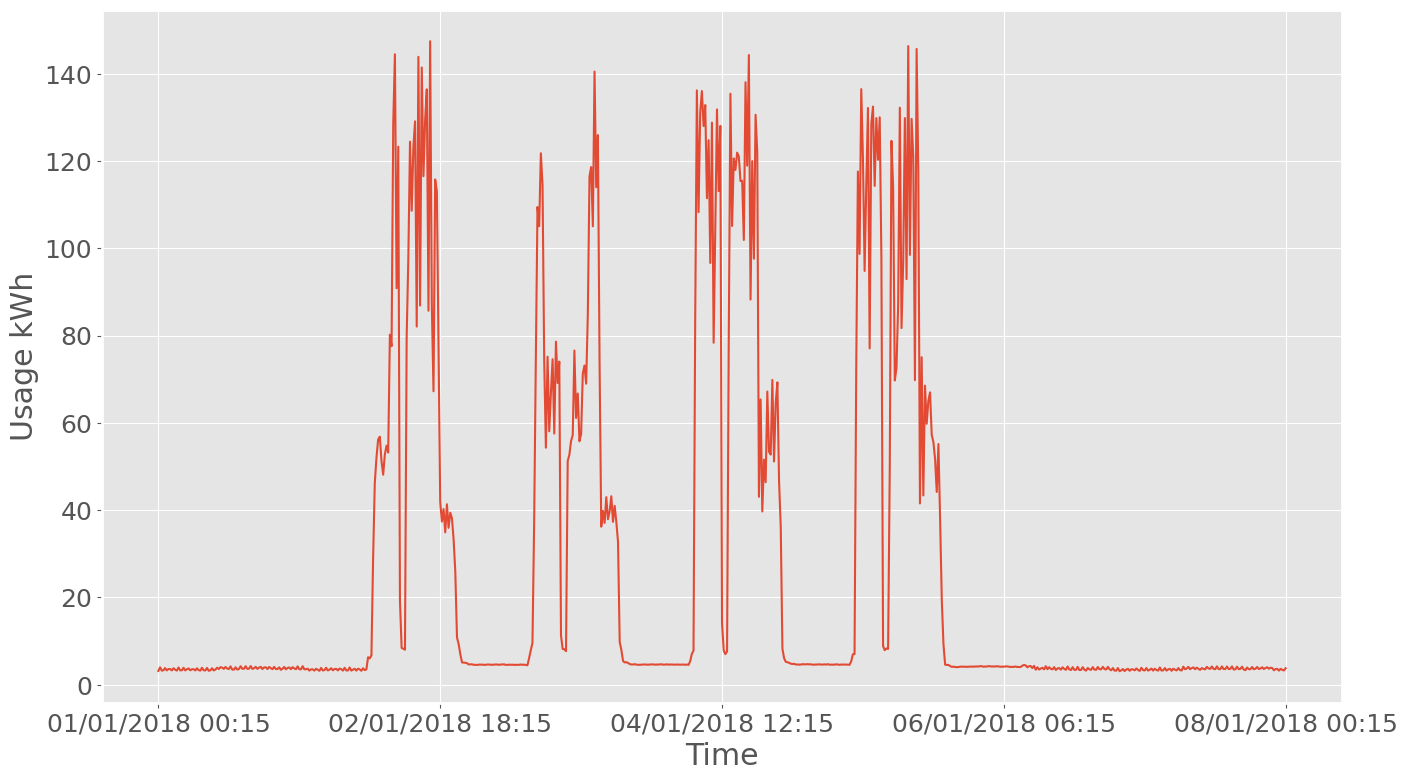

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Usage kWh')
plt.savefig('UsageWeek.png')
plt.show()

In [5]:
#replace 0 value with the minimum value except 0
second_min = min(load[load != 0])
load[load == 0] = second_min
display(load[load == 0])

C:\Users\sevann radhak\AppData\Local\Temp\ipykernel_6248\2982811346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load[load == 0] = second_min


Series([], Name: Usage_kWh, dtype: float64)

In [7]:
display(load.describe())

count    35040.000000
mean        27.386962
std         33.444325
min          2.450000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64

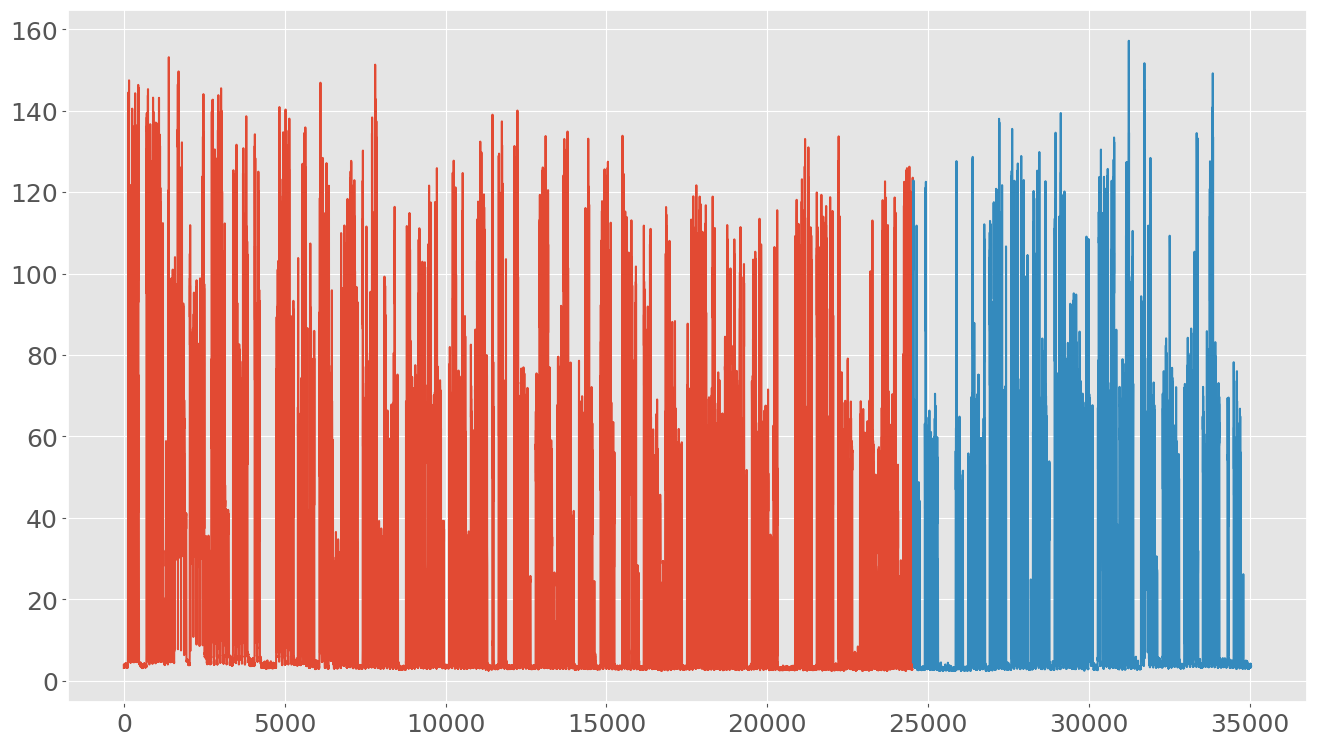

In [9]:
train = load[:int(len(load)*0.7)]
test = load[int(len(load)*0.7):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1600x900 with 0 Axes>

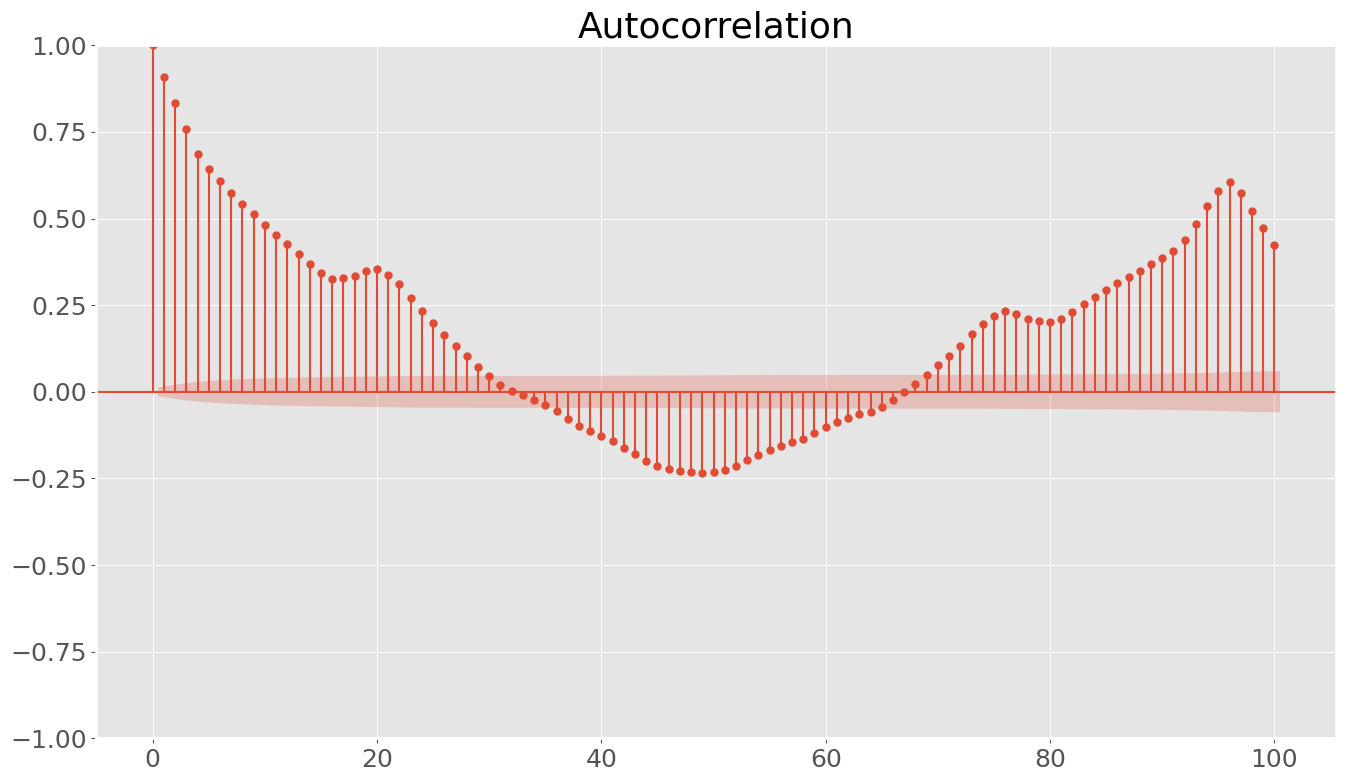

<Figure size 1600x900 with 0 Axes>

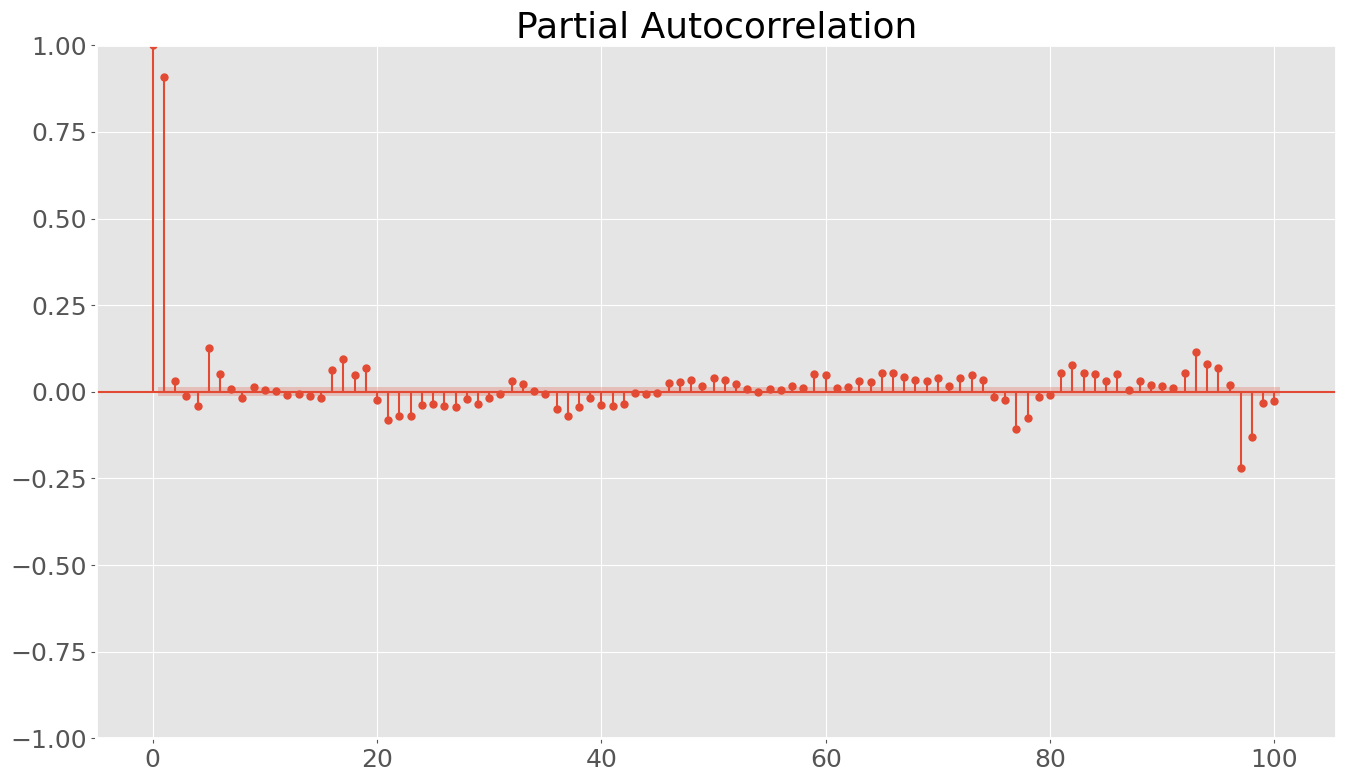

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=100)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=100)
plt.show()

In [11]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,4):
    df_train["lag{}".format(i)] = df_train["Usage_kWh"].shift(i)
    df_test["lag{}".format(i)] = df_test["Usage_kWh"].shift(i)

# df_train = pd.merge(df_train, other_vars_train, left_index=True, right_index=True, how = 'outer')
# df_test = pd.merge(df_test, other_vars_test, left_index=True, right_index=True, how = 'outer')

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = ["Usage_kWh"])
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ["Usage_kWh"])

display(df_train, df_test)

lag1   lag2    lag3
0       0.00   0.00    0.00
1       3.17   0.00    0.00
2       4.00   3.17    0.00
3       3.24   4.00    3.17
4       3.31   3.24    4.00
...      ...    ...     ...
24523  51.80  78.44  123.55
24524  53.60  51.80   78.44
24525  50.33  53.60   51.80
24526  51.01  50.33   53.60
24527  56.45  51.01   50.33

[24528 rows x 3 columns]

lag1  lag2  lag3
24528  0.00  0.00  0.00
24529  7.31  0.00  0.00
24530  4.43  7.31  0.00
24531  4.50  4.43  7.31
24532  5.08  4.50  4.43
...     ...   ...   ...
35035  3.82  3.67  3.24
35036  3.85  3.82  3.67
35037  3.74  3.85  3.82
35038  3.78  3.74  3.85
35039  3.78  3.78  3.74

[10512 rows x 3 columns]

# ARIMA

In [12]:
from statsmodels.tsa.arima.model import ARIMA
 
# Build Model
arima = ARIMA(train, order=(1, 1, 1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Usage_kWh   No. Observations:                24528
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -100066.324
Date:                Thu, 03 Oct 2024   AIC                         200138.648
Time:                        17:32:00   BIC                         200162.971
Sample:                             0   HQIC                        200146.528
                              - 24528                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9072      0.002    454.407      0.000       0.903       0.911
ma.L1         -0.9995      0.000  -4001.000      0.000      -1.000      -0.999
sigma2       204.7160      0.868    235.972      0.0

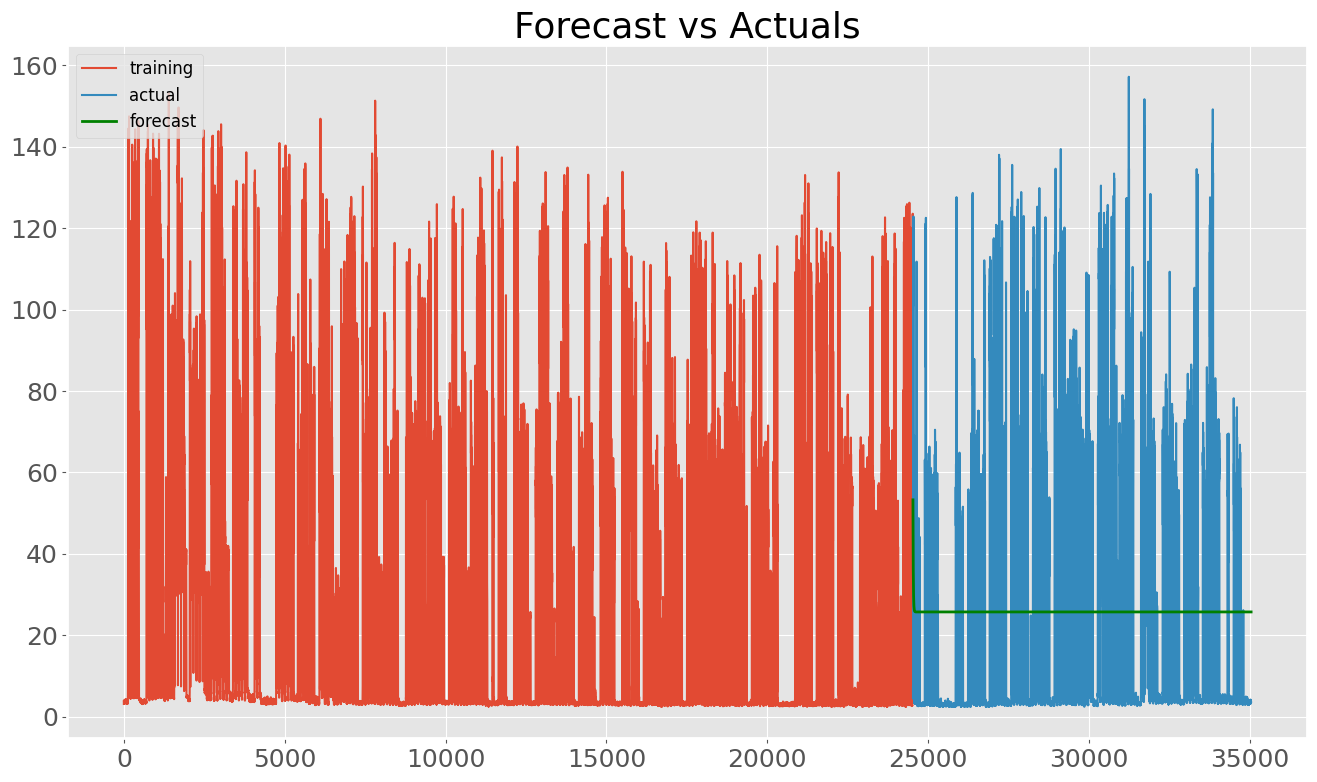

In [13]:
# plotting
arima_fc = arima.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(arima_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(fc_series, label='forecast', linewidth = 2, c = 'g')
# plt.plot(arima.predict(), label = 'fit')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('ARIMA.png')
plt.show()

In [14]:
RMSE_ARIMA = mean_squared_error(test, arima_fc)
MAE_ARIMA  =mean_absolute_error(test, arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

RMSE = 956.6311354356972 
MAE = 26.787527287733692 
MAPE = 4.261957353048606


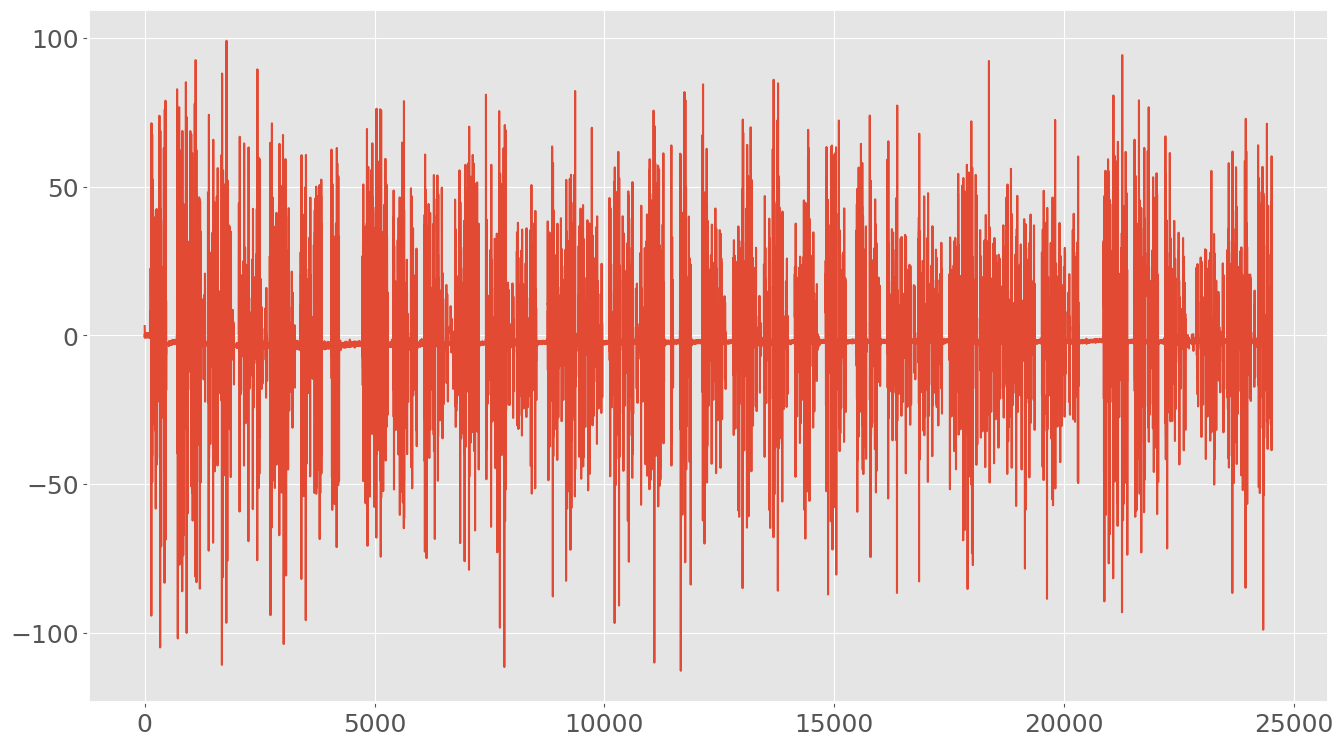

In [15]:
plt.plot(arima.resid)
plt.savefig('arimaresid')
plt.show()

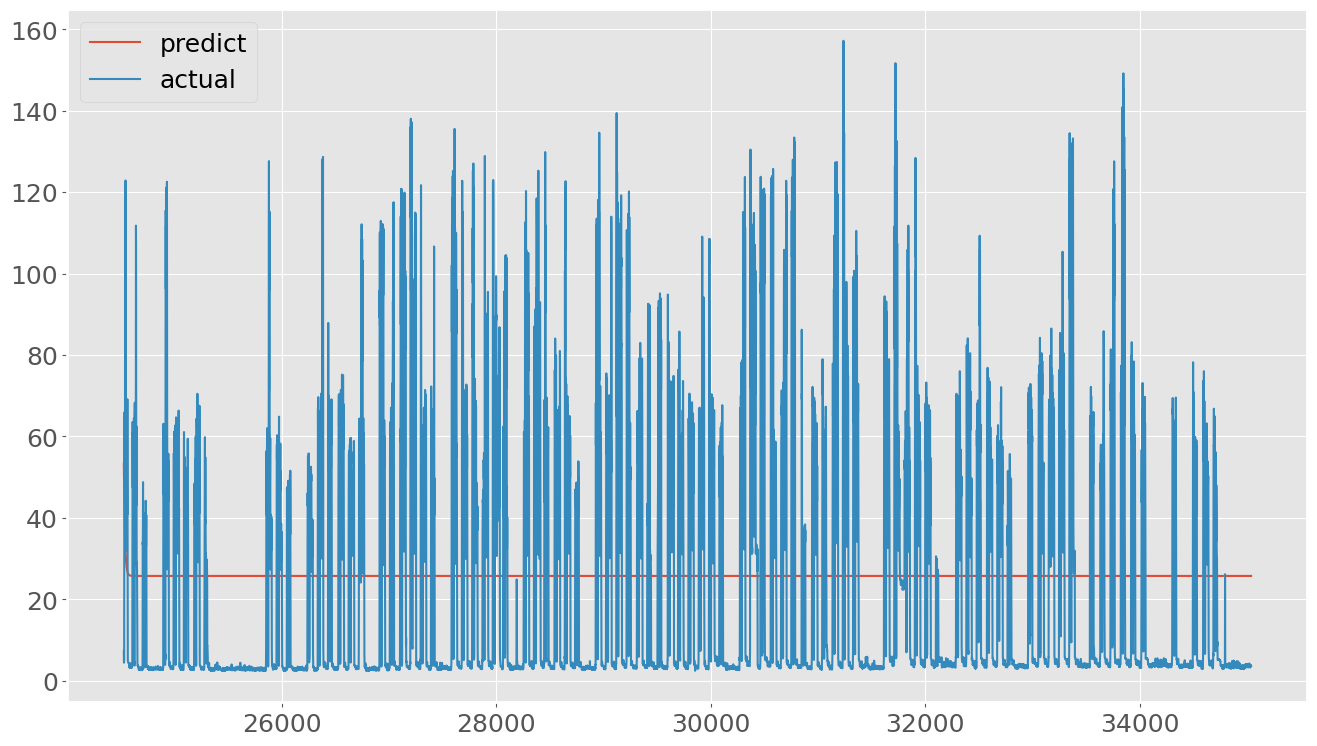

In [16]:
plt.plot(arima_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('ARIMApredict')
plt.show()

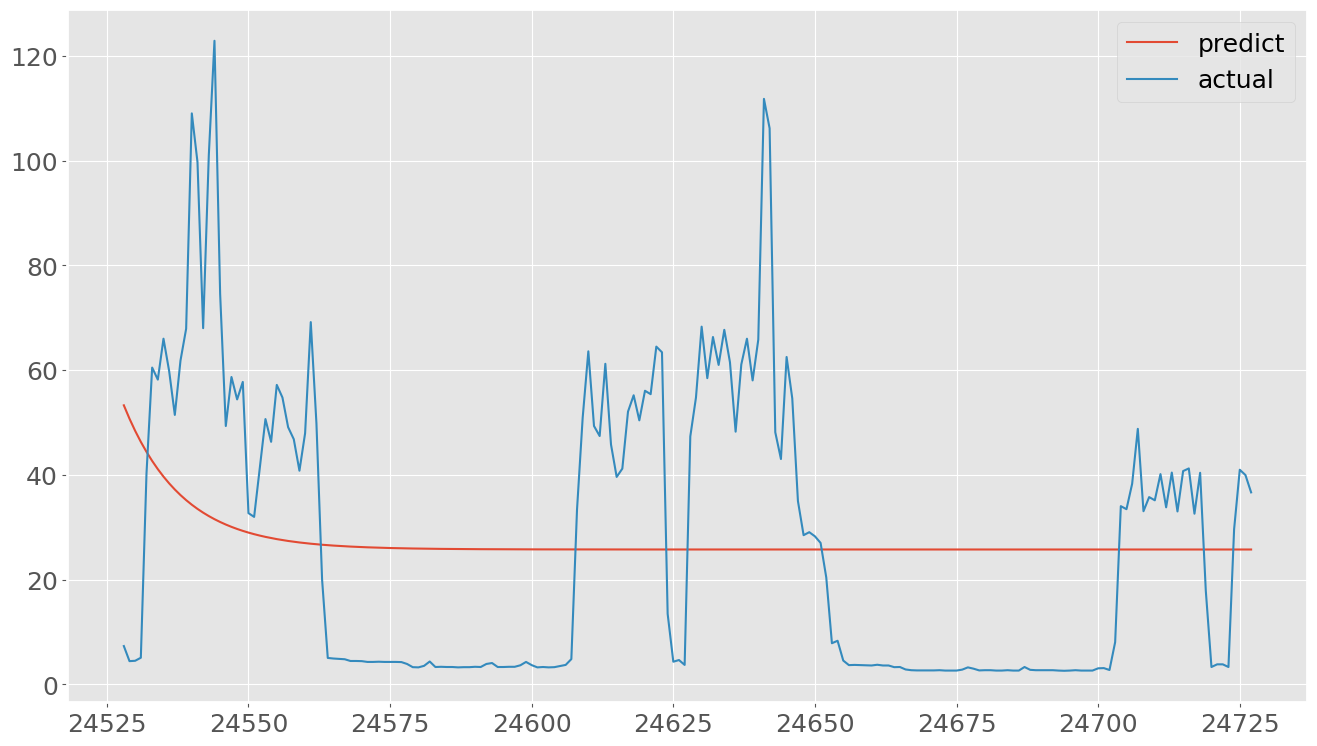

In [17]:
plt.plot(arima_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('ARIMApredict_200')
plt.show()

In [18]:
arima_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
arima_SVR.fit(df_train.values, arima.resid)
arima_SVR_fc = arima_SVR.predict(np.array(df_test))

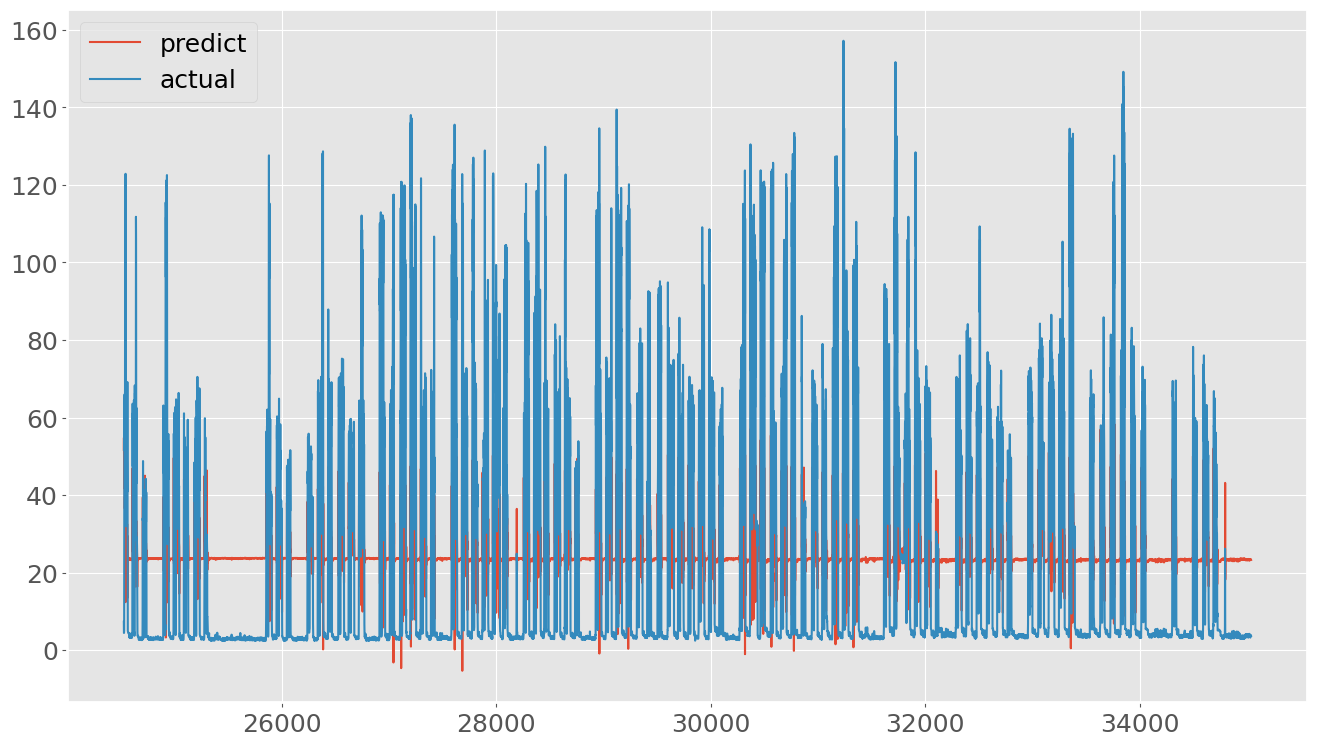

In [19]:
# print(arimia_SVR)
plt.plot(arima_SVR_fc+arima_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('ARIMASVR')
plt.show()

In [20]:
RMSE_arima_svm = mean_squared_error(test, arima_SVR_fc+arima_fc)
MAE_arima_svm  =mean_absolute_error(test, arima_SVR_fc+arima_fc)
MAPE_arima_svm = mean_absolute_percentage_error(test, arima_SVR_fc+arima_fc)
print('RMSE = {}'.format(RMSE_arima_svm), '\nMAE = {}'.format(MAE_arima_svm), '\nMAPE = {}'.format(MAPE_arima_svm))

RMSE = 858.7251265138094 
MAE = 24.55089167483967 
MAPE = 3.8310114732548355


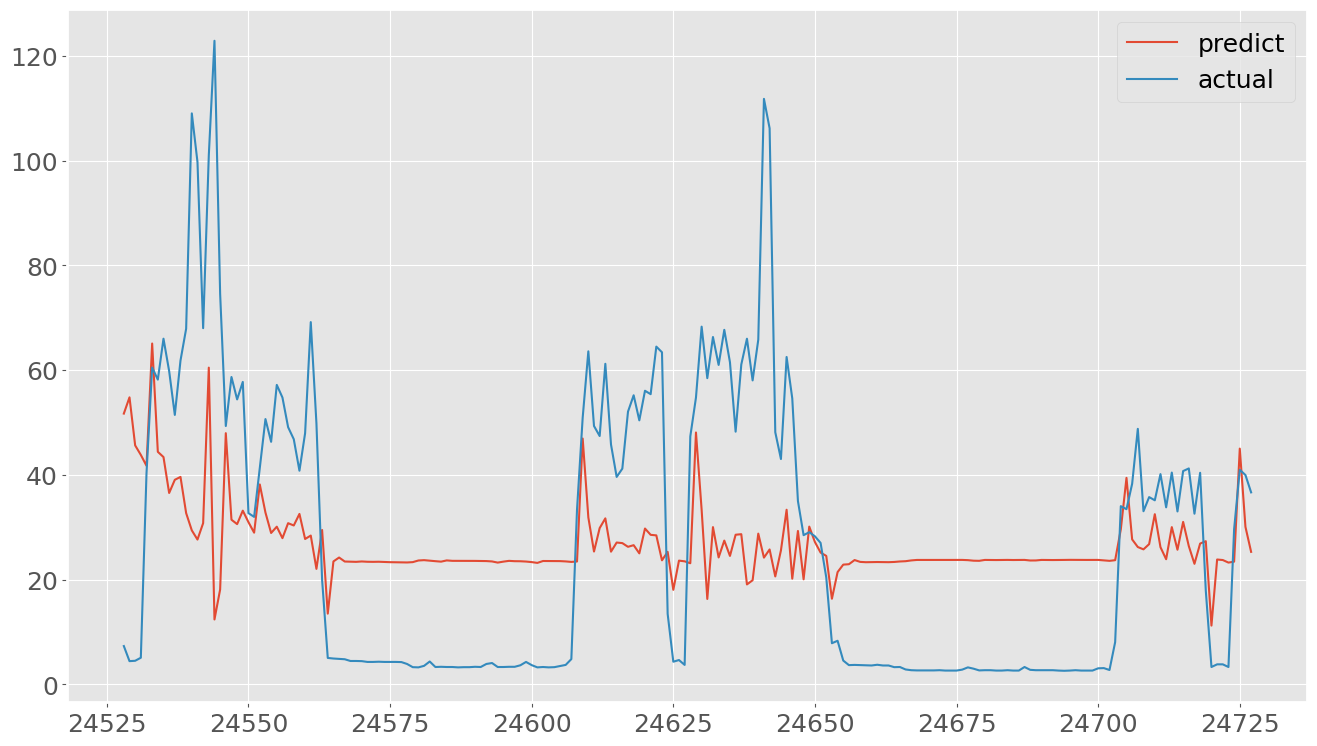

In [21]:
#test area
plt.plot(arima_SVR_fc[:200]+arima_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('ARIMASVR_200')
plt.show()

# Holt-Winter - SVM

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
holt_winter = HWES(train, seasonal_periods=12, trend = 'add', seasonal='add').fit()
print(holt_winter.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                Usage_kWh   No. Observations:                24528
Model:             ExponentialSmoothing   SSE                        5079680.584
Optimized:                         True   AIC                         130844.444
Trend:                         Additive   BIC                         130974.165
Seasonal:                      Additive   AICC                        130844.471
Seasonal Periods:                    12   Date:                 Thu, 03 Oct 2024
Box-Cox:                          False   Time:                         17:37:20
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9299136                alpha                 True
smoothing_trend          

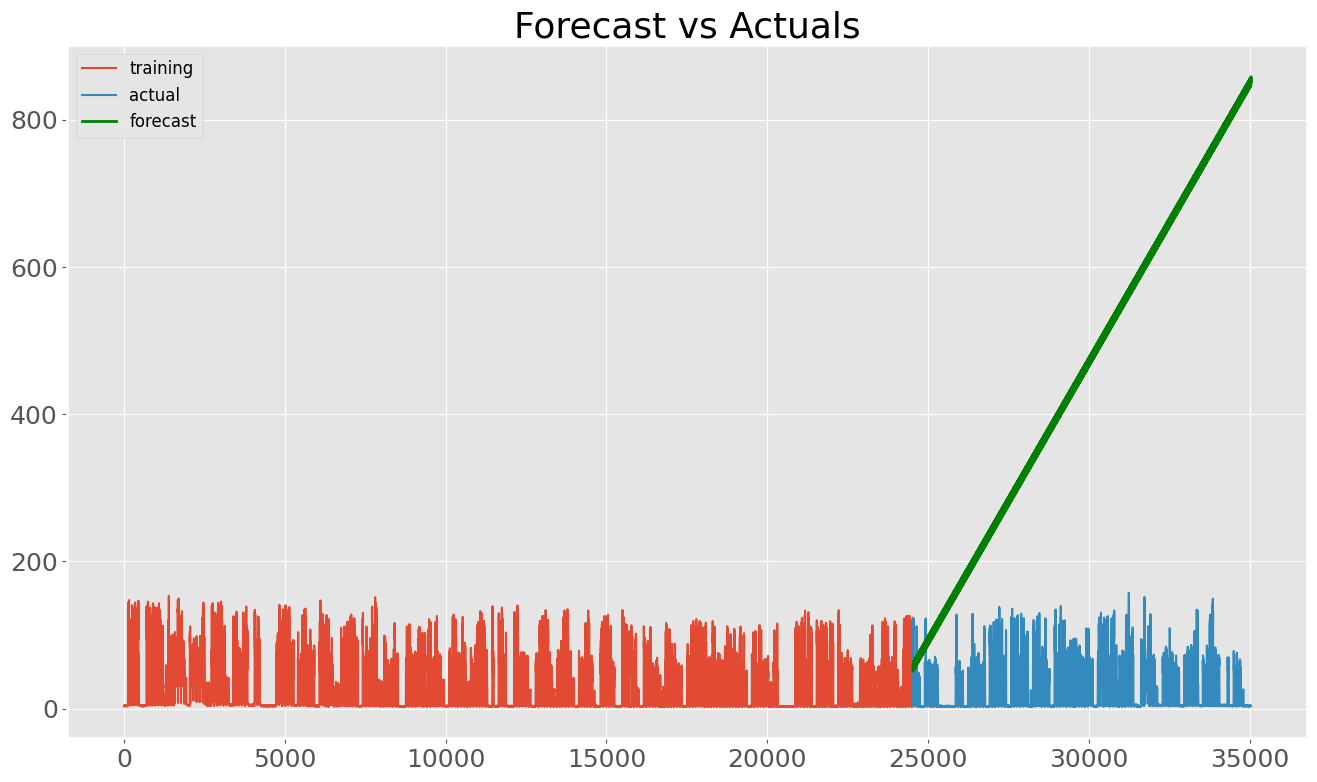

24528    50.837992
dtype: float64


In [23]:
hw_fc = holt_winter.forecast(len(test)) 

# Make as pandas series
hw_series = pd.Series(hw_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(hw_series, label='forecast', linewidth = 2, c = 'g')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('HW')
plt.show()
print(holt_winter.predict(len(train)))

In [24]:
RMSE_HW = mean_squared_error(test, hw_fc)
MAE_HW  =mean_absolute_error(test, hw_fc)
MAPE_HW = mean_absolute_percentage_error(test, hw_fc)
print('RMSE = {}'.format(RMSE_HW), '\nMAE = {}'.format(MAE_HW), '\nMAPE = {}'.format(MAPE_HW))

RMSE = 238977.7237910583 
MAE = 430.4897099419857 
MAPE = 81.39572076853841


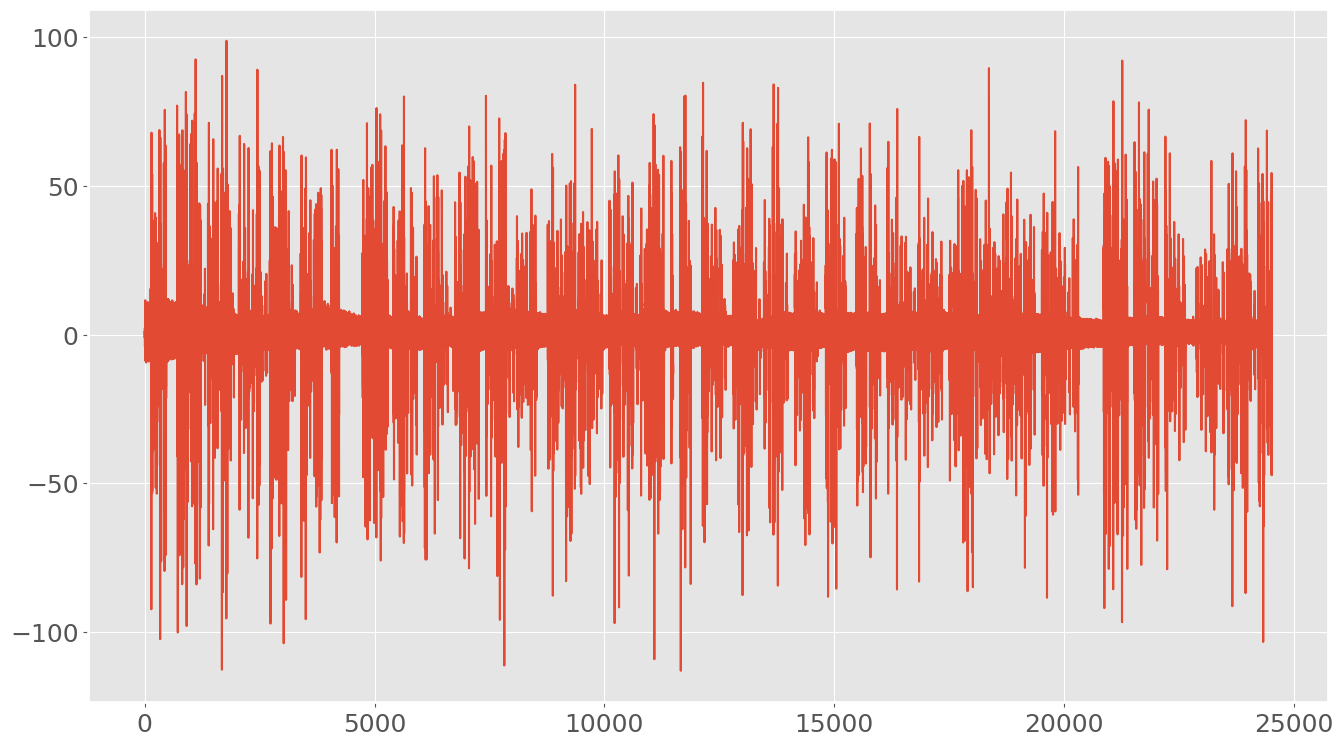

In [25]:
plt.plot(holt_winter.resid)
plt.savefig('hwresid')
plt.show()

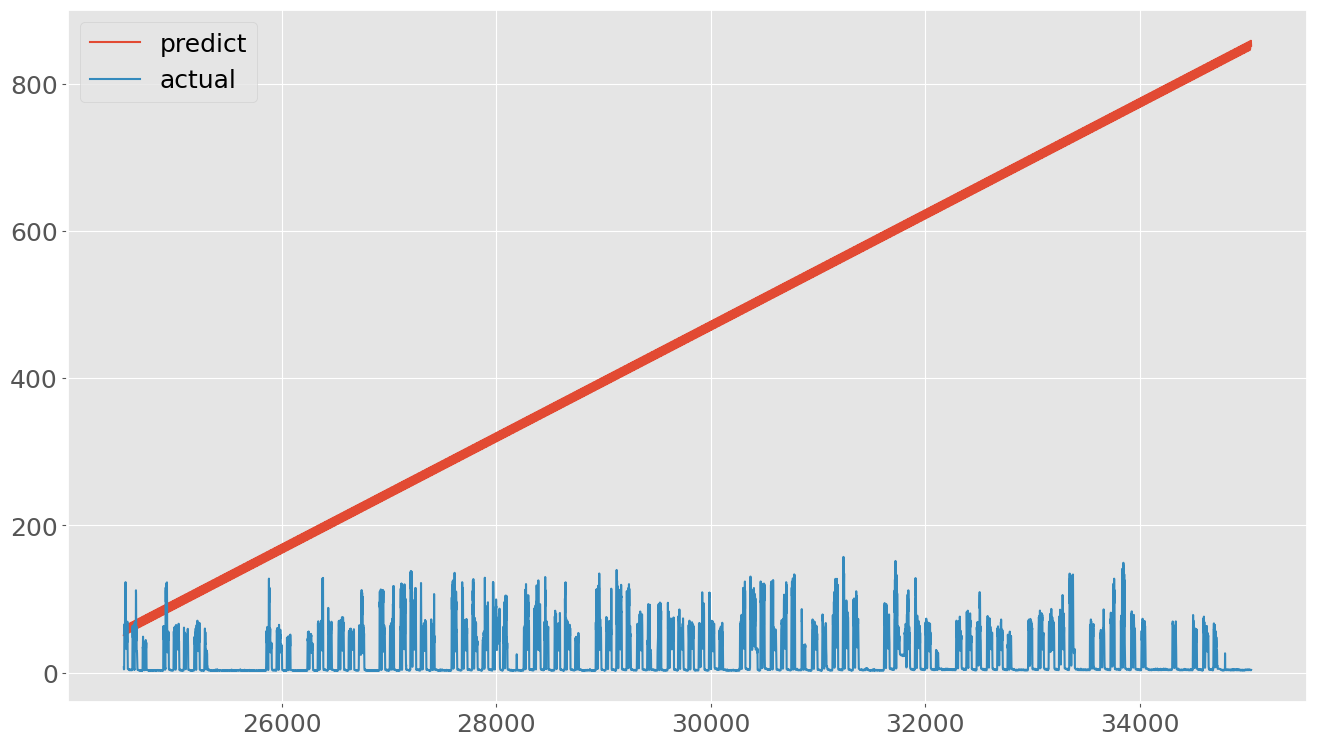

In [26]:
plt.plot(hw_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('HWpredict')
plt.show()

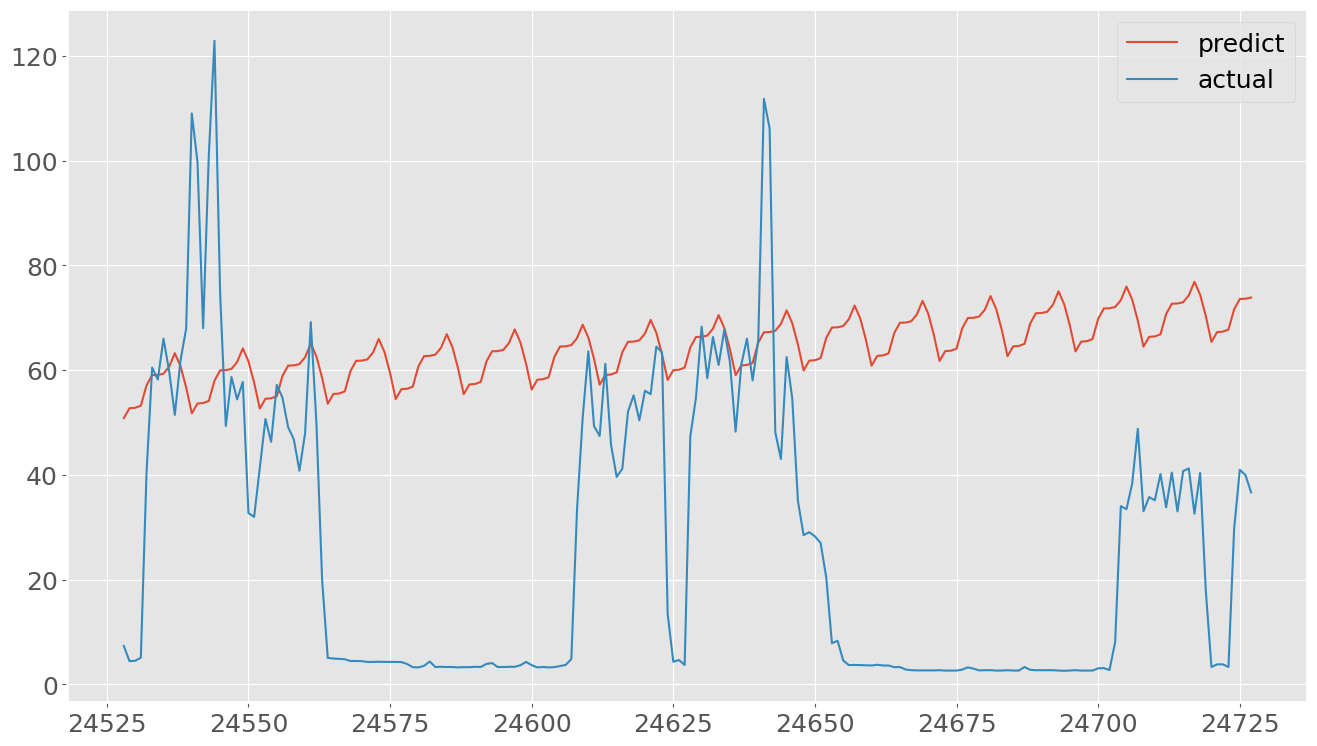

In [27]:
plt.plot(hw_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('HWpredict_200')
plt.show()

In [28]:
hw_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
hw_SVR.fit(df_train.values, holt_winter.resid)

hw_SVR_fc = hw_SVR.predict(np.array(df_test))

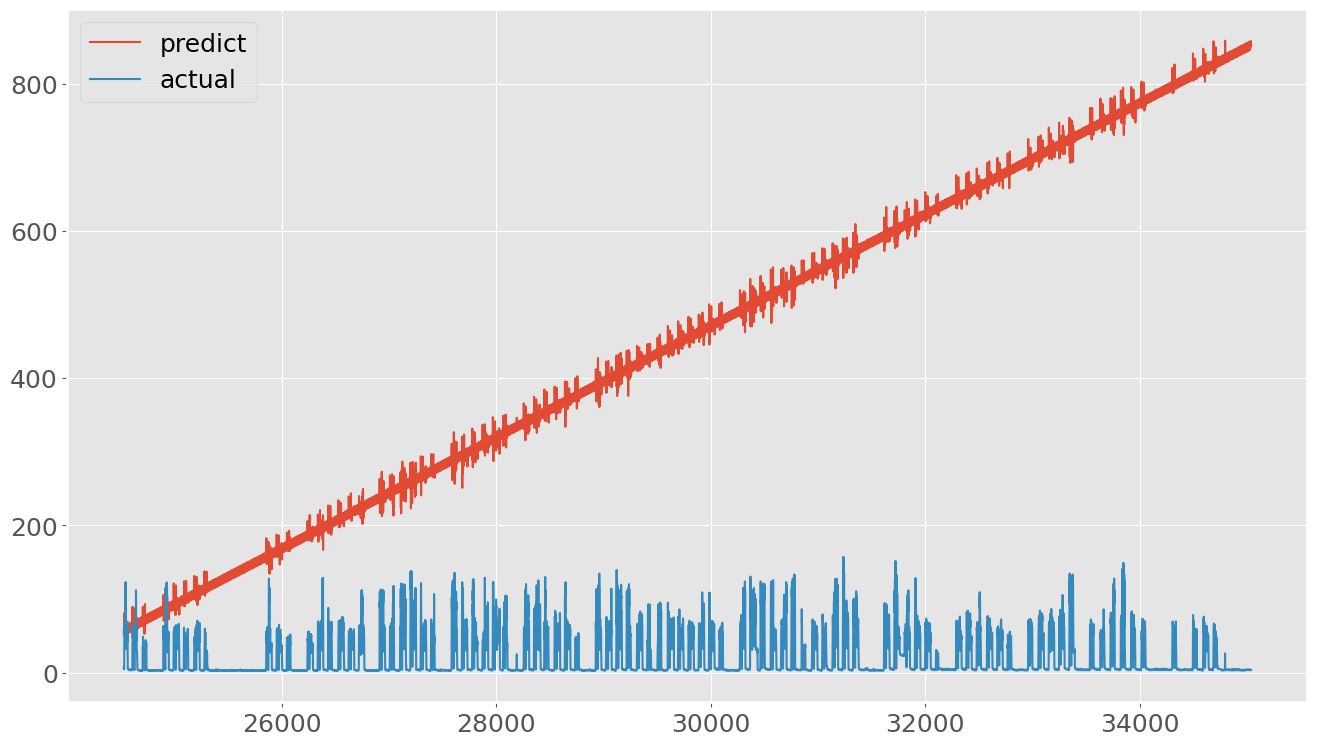

In [29]:
plt.plot(hw_SVR_fc+hw_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
plt.savefig('HWSVR')
plt.show()

In [30]:
RMSE_hw_SVR = mean_squared_error(test, hw_SVR_fc+hw_fc)
MAE_hw_SVR  =mean_absolute_error(test, hw_SVR_fc+hw_fc)
MAPE_hw_SVR = mean_absolute_percentage_error(test, hw_SVR_fc+hw_fc)
print('RMSE = {}'.format(RMSE_hw_SVR), '\nMAE = {}'.format(MAE_hw_SVR), '\nMAPE = {}'.format(MAPE_hw_SVR))

RMSE = 238821.04753620867 
MAE = 430.3173843750069 
MAPE = 81.37318953418398


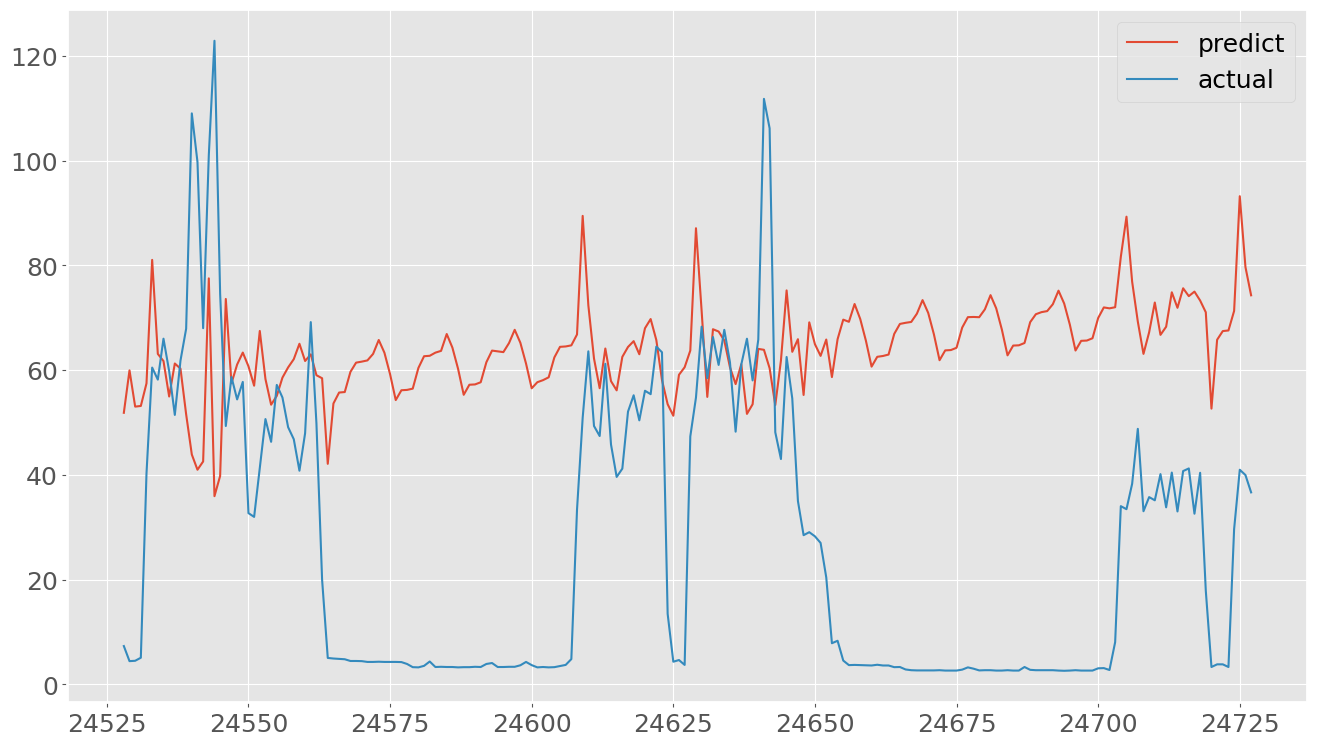

In [31]:
plt.plot(hw_SVR_fc[:200]+hw_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
plt.savefig('HWSVR_200')
plt.show()

# SVM

In [32]:
SVR_m = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(df_train.values, train)

SVR_fc = SVR_m.predict(np.array(df_test))

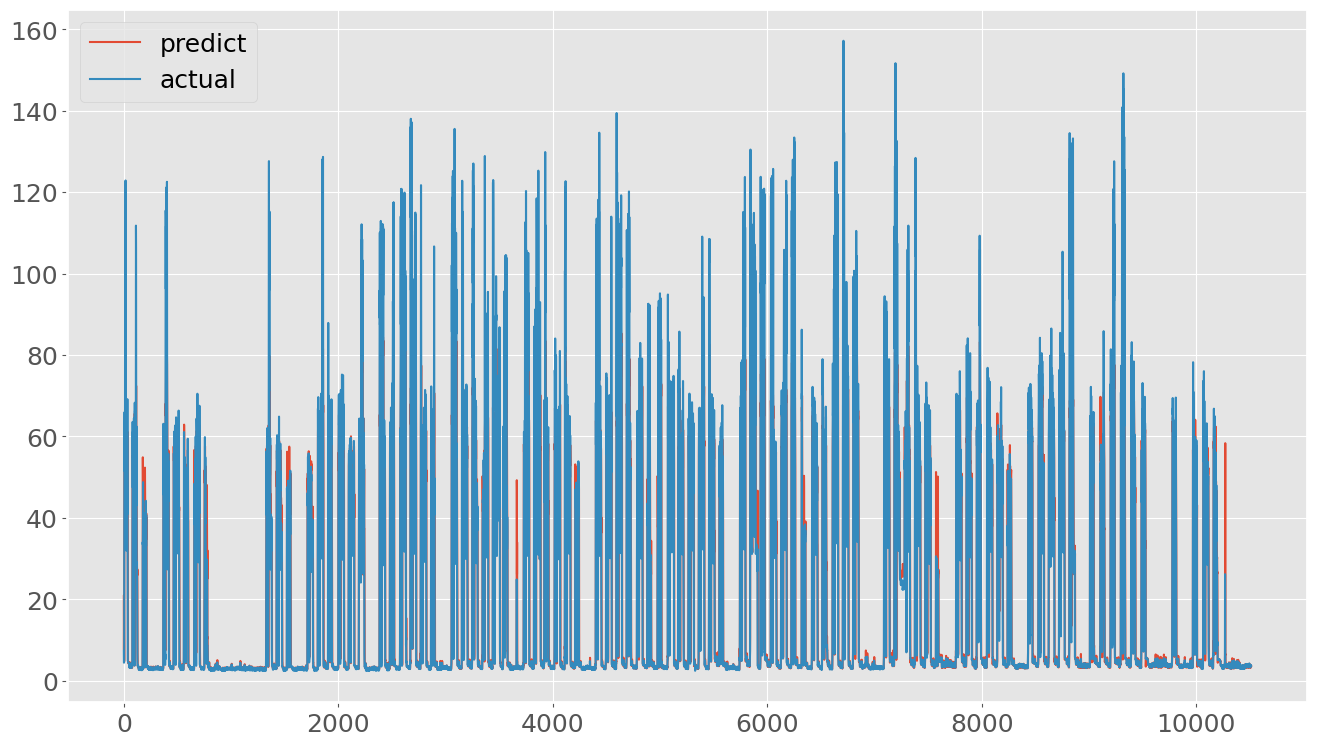

In [33]:
plt.plot(SVR_fc, label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('SVR')
plt.show()

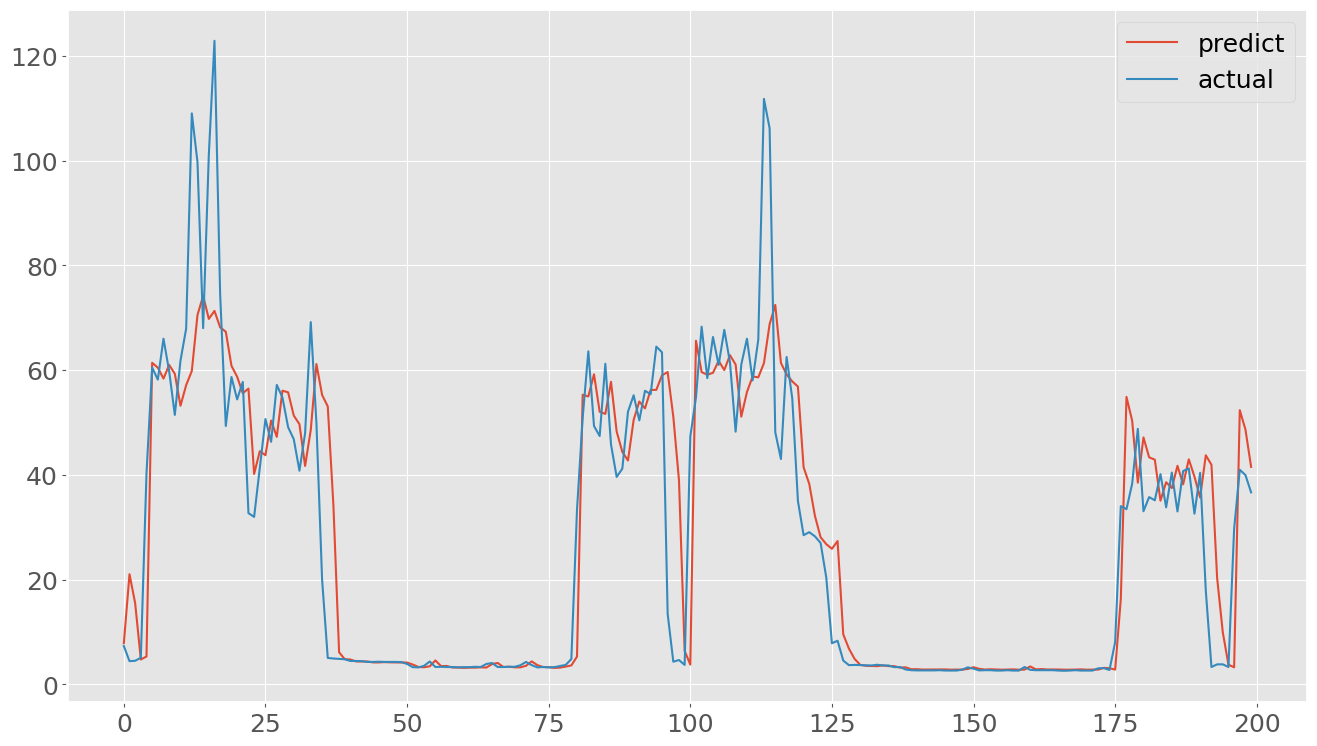

In [34]:
plt.plot(SVR_fc[:200], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
plt.savefig('SVR_200')
plt.show()

In [35]:
RMSE_SVR = mean_squared_error(test, SVR_fc)
MAE_SVR  =mean_absolute_error(test, SVR_fc)
MAPE_SVR = mean_absolute_percentage_error(test, SVR_fc)
print('RMSE = {}'.format(RMSE_SVR), '\nMAE = {}'.format(MAE_SVR), '\nMAPE = {}'.format(MAPE_SVR))

RMSE = 190.56766726507308 
MAE = 6.360496584145869 
MAPE = 0.3986853208902765


# Moving Average 3

In [36]:
MA_3_train = pd.DataFrame(train).rolling(window=3).mean().fillna(0)
MA_3_test = pd.DataFrame(test).rolling(window=3).mean().fillna(0)
# display(MA_3_train, MA_3_test)

In [37]:
SVR_MA_3 = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(MA_3_train.values, train)
SVR_MA_3_fc = SVR_MA_3.predict(np.array(MA_3_test))

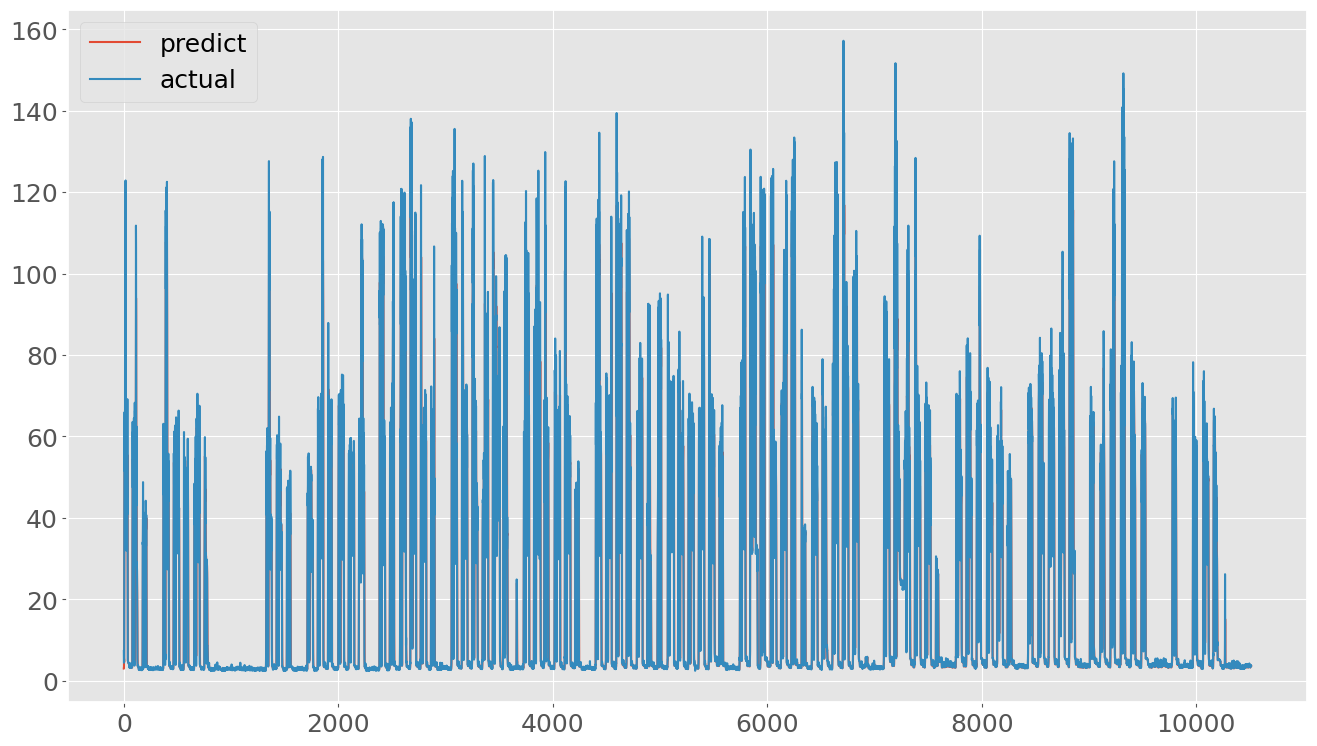

In [38]:
plt.plot(SVR_MA_3_fc, label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('SVR_MA3')
plt.show()

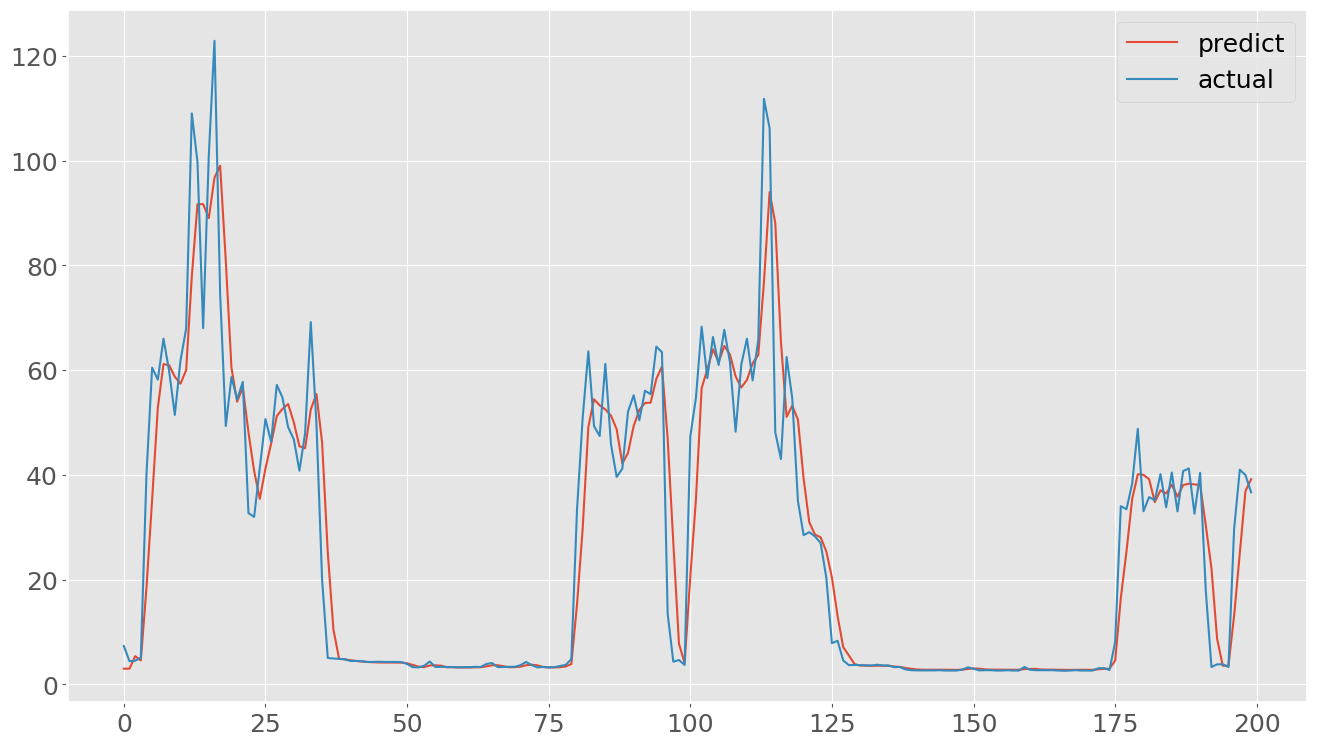

In [39]:
plt.plot(SVR_MA_3_fc[0:200], label = 'predict')
plt.plot(test.values[0:200], label = 'actual')
plt.legend()
plt.savefig('SVR_MA3_200')
plt.show()

In [40]:
RMSE_SVR_MA3 = mean_squared_error(test, SVR_MA_3_fc)
MAE_SVR_MA3  =mean_absolute_error(test, SVR_MA_3_fc)
MAPE_SVR_MA3 = mean_absolute_percentage_error(test, SVR_MA_3_fc)
print('RMSE = {}'.format(RMSE_SVR_MA3), '\nMAE = {}'.format(MAE_SVR_MA3), '\nMAPE = {}'.format(MAPE_SVR_MA3))

RMSE = 85.07899386401557 
MAE = 4.158392542018961 
MAPE = 0.21261720913395118


# Empirical M Decomposition - SVM¶

In [41]:
!pip install emd

  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl (156 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   --------------------- ------------------ 15.2/28.1 MB 73.6 MB/s eta 0:00:01
   ---------------------------------------  28.0/28.1 MB 71.1 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 63.7 MB/s eta 0:00:00


 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


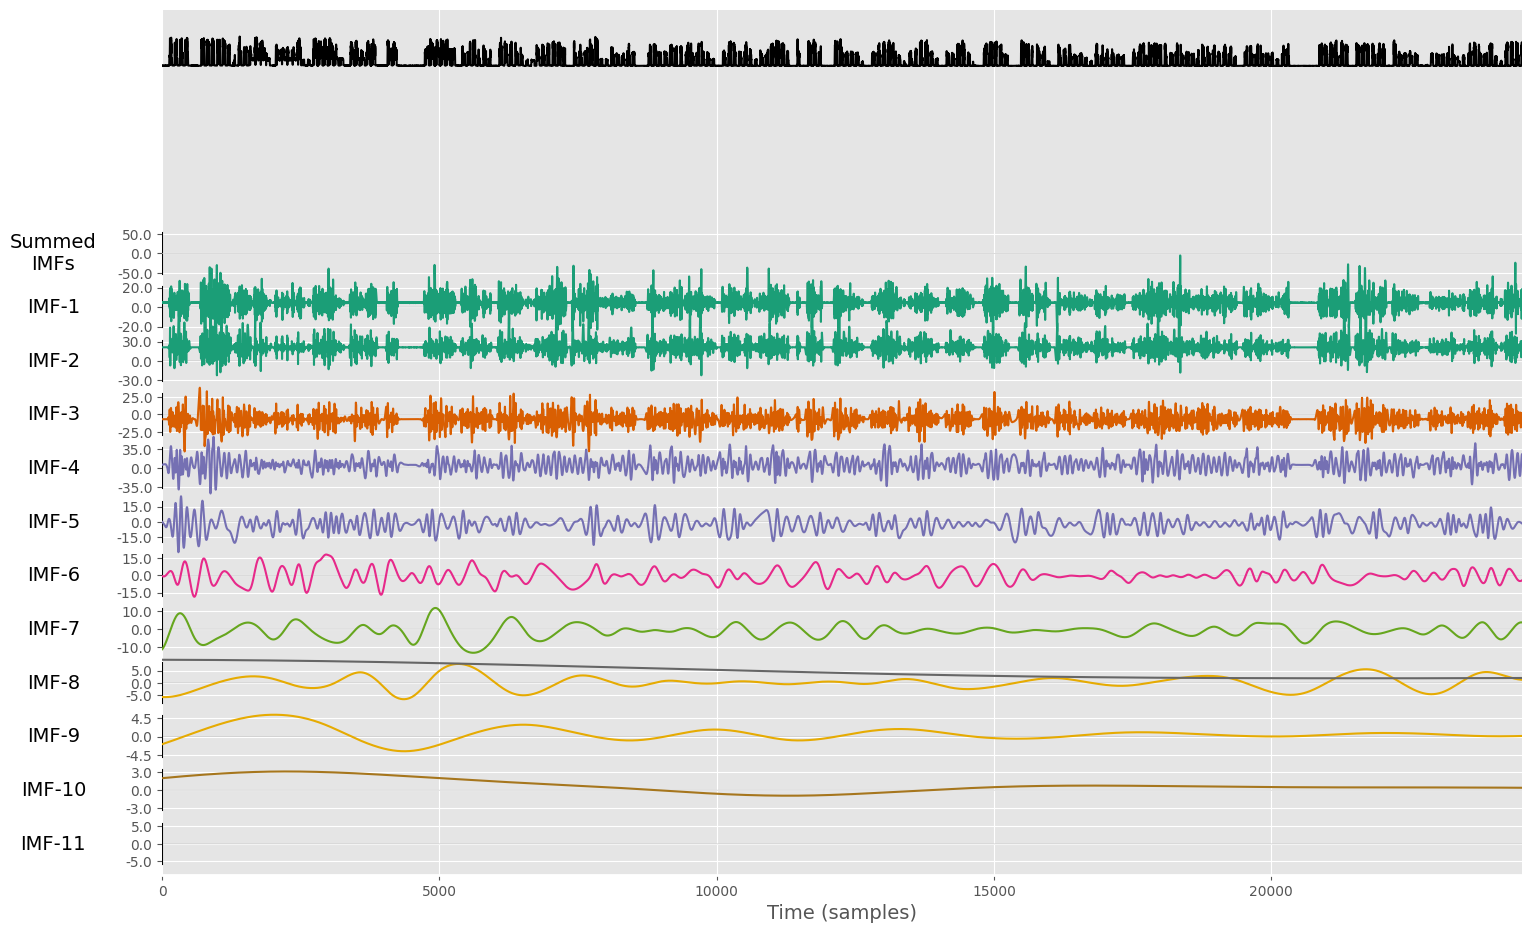

In [42]:
import emd

imf = emd.sift.sift(np.array(train), imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)
plt.savefig('emd')
plt.show()

In [43]:
#put the imf into dataframe
imf_df = pd.DataFrame(data = imf)
imf_df.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
display(imf_df)

imf_1      imf_2      imf_3      imf_4     imf_5     imf_6  \
0     -0.410418   0.096734   0.012662   0.266056  4.654688  0.067477   
1      0.400239   0.121368  -0.002632   0.334189  4.568617  0.017735   
2     -0.368732   0.130672  -0.013657   0.404290  4.477960 -0.030306   
3     -0.285557   0.112370  -0.019505   0.475967  4.382699 -0.076631   
4      0.264102   0.062765  -0.020476   0.548891  4.282814 -0.121229   
...         ...        ...        ...        ...       ...       ...   
24523  2.139145 -10.275599  -4.272019  39.139285  1.708957 -7.500440   
24524  2.974048  -9.148159  -9.567093  39.219571  1.639081 -7.438328   
24525 -0.504868  -0.677014 -13.606295  38.962034  1.570491 -7.374875   
24526 -0.003040   6.863818 -15.593641  38.360157  1.503190 -7.310106   
24527 -0.002403   6.771069 -14.901958  37.412008  1.437164 -7.244042   

           imf_7      imf_8     imf_9    imf_10     imf_11  
0     -20.472990 -11.796666 -4.588843  3.082662  32.258638  
1     -20.403255 -11.799372 -4.579866  3.084406  32.258571  
2     -20.331976 -11.802020 -4.570887  3.086150  32.258505  
3     -20.259160 -11.804611 -4.561904  3.087894  32.258438  
4     -20.184814 -11.807144 -4.552917  3.089637  32.258371  
...          ...        ...       ...       ...        ...  
24523   9.255424   2.328822 -0.622215 -0.109875  21.808516  
24524   9.247855   2.325870 -0.621509 -0.109998  21.808661  
24525   9.239659   2.322986 -0.620802 -0.110122  21.808806  
24526   9.230840   2.320169 -0.620094 -0.110245  21.808951  
24527   9.221399   2.317419 -0.619384 -0.110368  21.809097  

[24528 rows x 11 columns]

In [44]:
imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_SVR.fit(df_train.values, imf_df['imf_1'])
imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_SVR.fit(df_train.values, imf_df['imf_2'])
imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_SVR.fit(df_train.values, imf_df['imf_3'])
imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_SVR.fit(df_train.values, imf_df['imf_4'])
imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_SVR.fit(df_train.values, imf_df['imf_5'])
imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_SVR.fit(df_train.values, imf_df['imf_6'])
imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_SVR.fit(df_train.values, imf_df['imf_7'])
imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_SVR.fit(df_train.values, imf_df['imf_8'])
imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_SVR.fit(df_train.values, imf_df['imf_9'])
imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_SVR.fit(df_train.values, imf_df['imf_10'])
imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

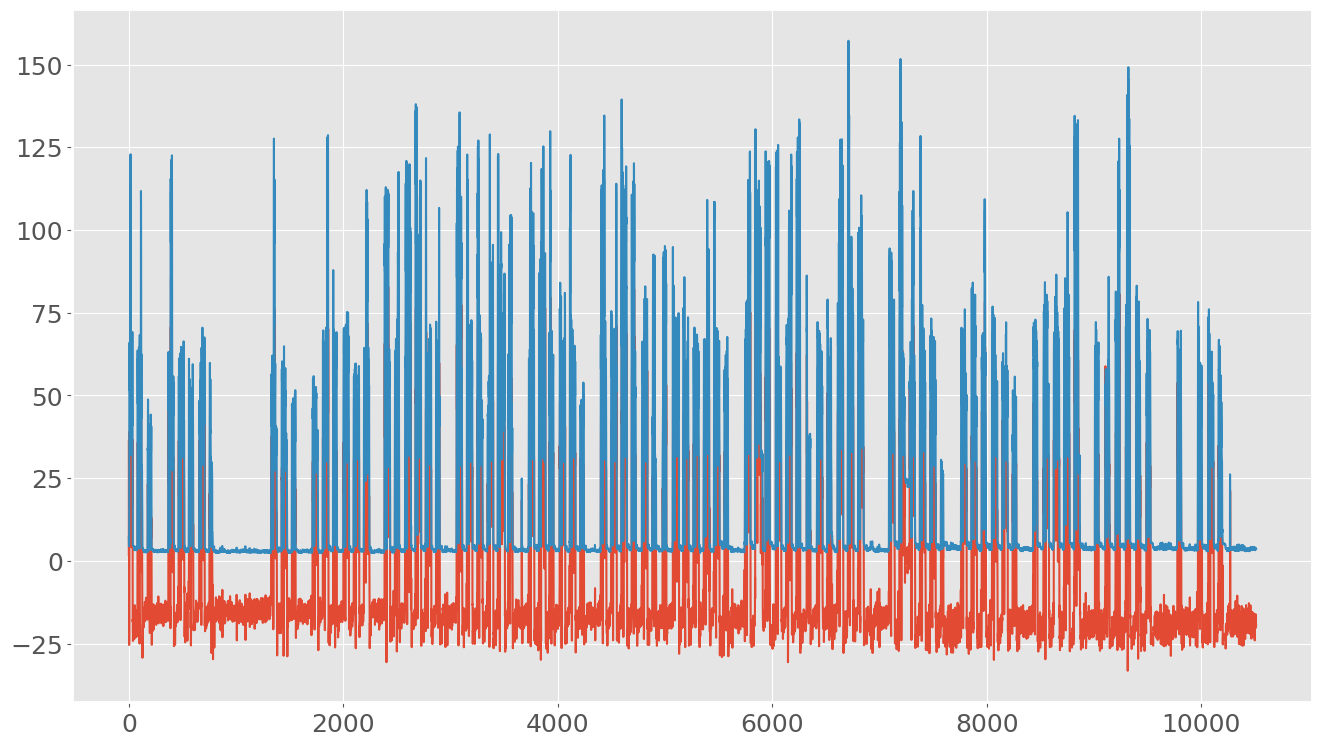

In [45]:
imf_list = ['imf{}_SVR_fc'.format(i) for i in range(1,11)]

imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc, imf10_SVR_fc], axis = 0)

plt.plot(imf_fc)
plt.plot(test.values)

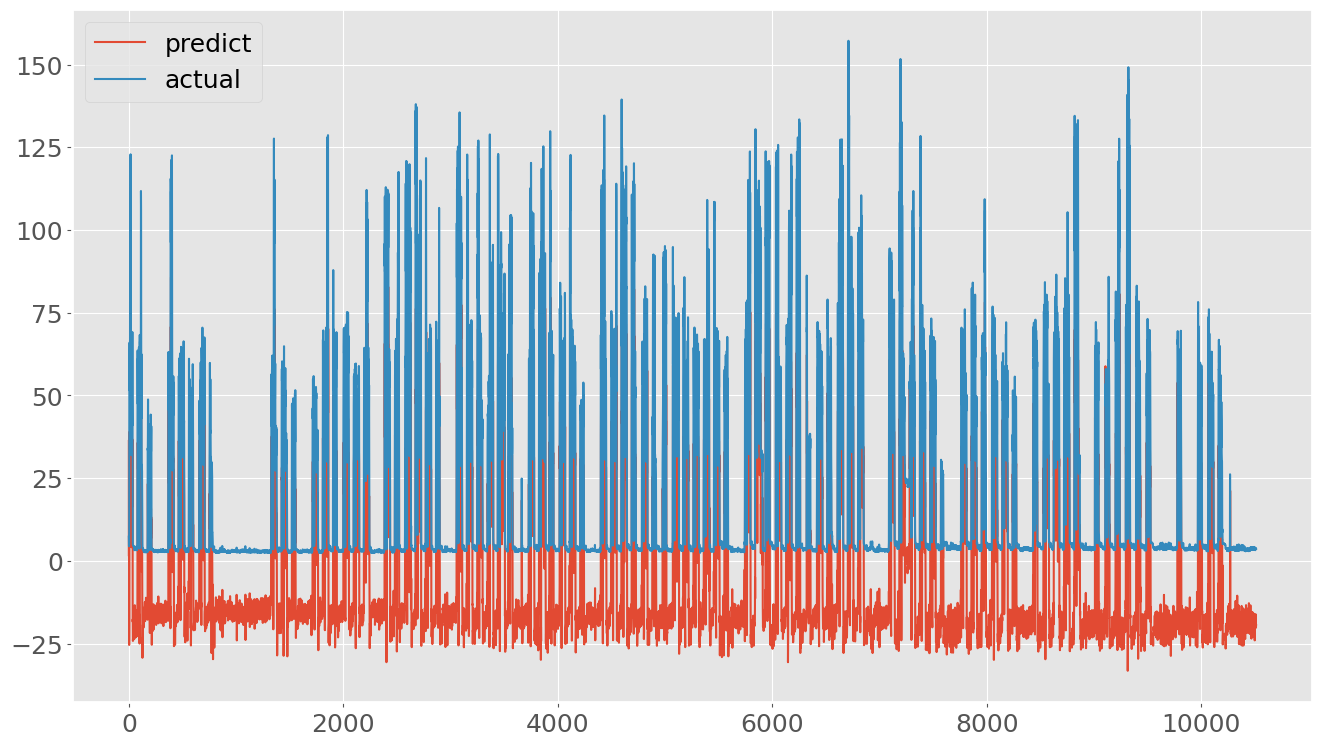

RMSE = 760.1370409963856 
MAE = 25.0986144655348 
MAPE = 4.045079437369323


In [46]:
plt.plot(imf_fc,label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('EMDSVR')
plt.show()

RMSE_EMD_SVR = mean_squared_error(test, imf_fc)
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc)
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

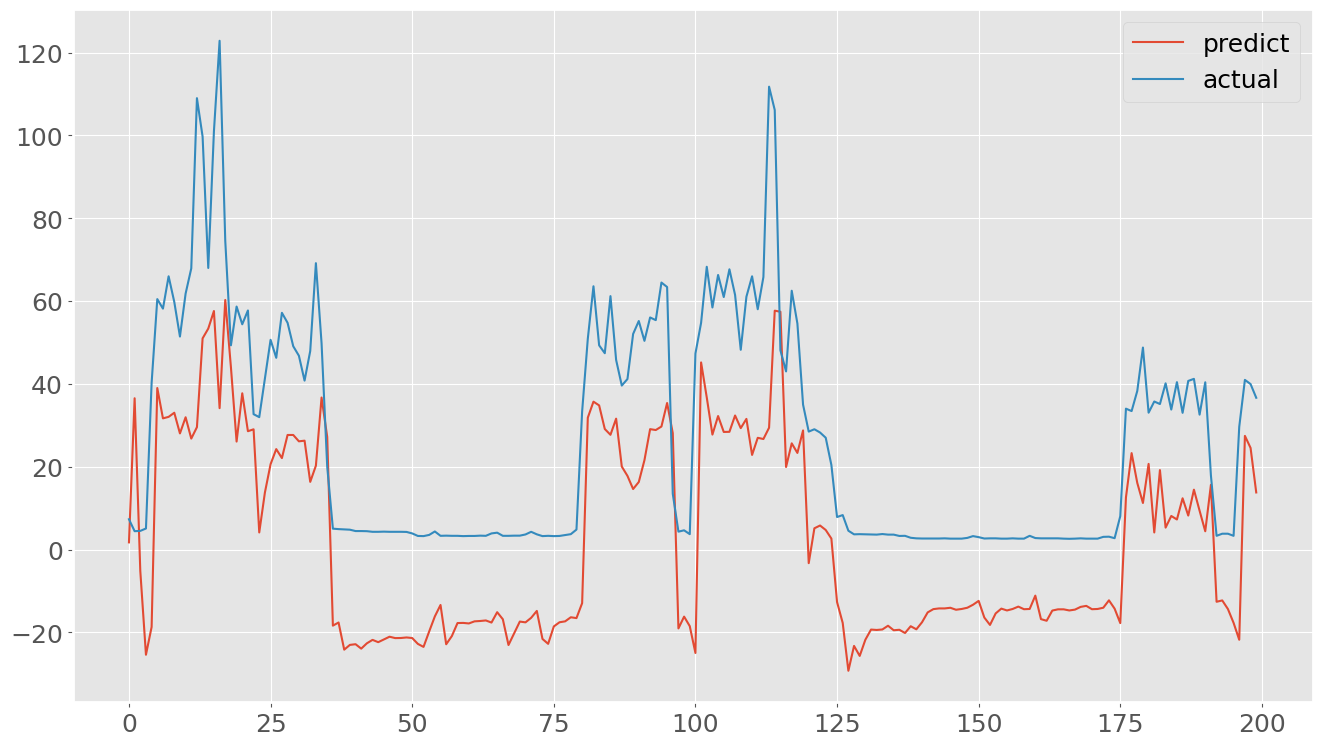

In [47]:
plt.plot(imf_fc[:200], label = 'predict')
plt.plot(test[:200].values, label = 'actual')
plt.legend()
plt.savefig('EMDSVR_200')
plt.show()

In [48]:
imf1_SVR_fc = imf1_SVR.predict(np.array(df_train))
imf2_SVR_fc = imf2_SVR.predict(np.array(df_train))
imf3_SVR_fc = imf3_SVR.predict(np.array(df_train))
imf4_SVR_fc = imf4_SVR.predict(np.array(df_train))
imf5_SVR_fc = imf5_SVR.predict(np.array(df_train))
imf6_SVR_fc = imf6_SVR.predict(np.array(df_train))
imf7_SVR_fc = imf7_SVR.predict(np.array(df_train))
imf8_SVR_fc = imf8_SVR.predict(np.array(df_train))
imf9_SVR_fc = imf9_SVR.predict(np.array(df_train))
imf10_SVR_fc = imf10_SVR.predict(np.array(df_train))

imf_fc_train = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc, imf10_SVR_fc], axis = 0)

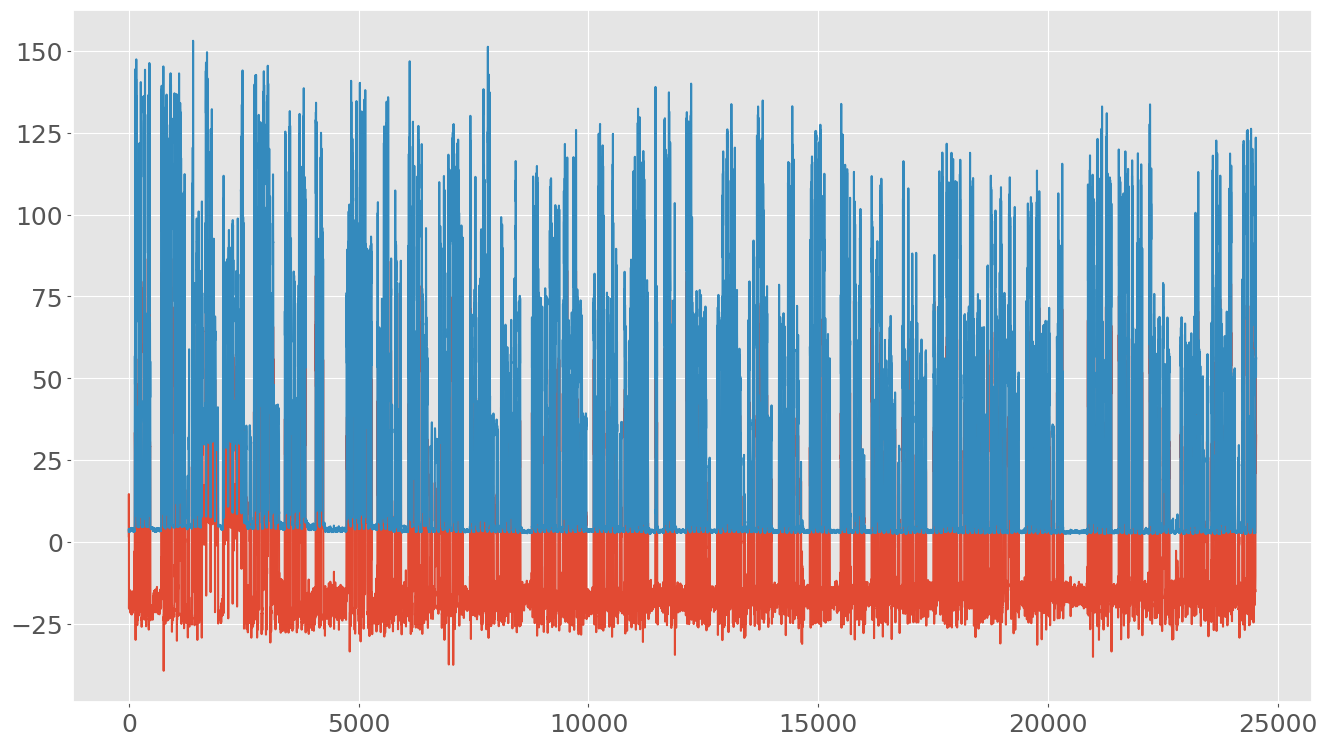

In [49]:
plt.plot(imf_fc_train)
plt.plot(train.values)

In [50]:
RMSE_EMD_SVR = mean_squared_error(train, imf_fc_train, squared = False)
MAE_EMD_SVR  =mean_absolute_error(train, imf_fc_train)
MAPE_EMD_SVR = mean_absolute_percentage_error(train, imf_fc_train)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 28.928843953578728 
MAE = 26.052914513961365 
MAPE = 3.717170324110286


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
import numpy as np
from scipy.optimize import minimize

def dummy(c):
    global  train
    global imf_fc_train
    return mean_squared_error(train, imf_fc_train + c, squared = False)

res = minimize(dummy, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 13.776087
         Iterations: 47
         Function evaluations: 98
[25.43810986]


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

In [52]:
RMSE_EMD_SVR = mean_squared_error(test, imf_fc + res.x[0])
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc + res.x[0])
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc + res.x[0])
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 161.2115763195255 
MAE = 8.082470564921893 
MAPE = 1.058941505055023


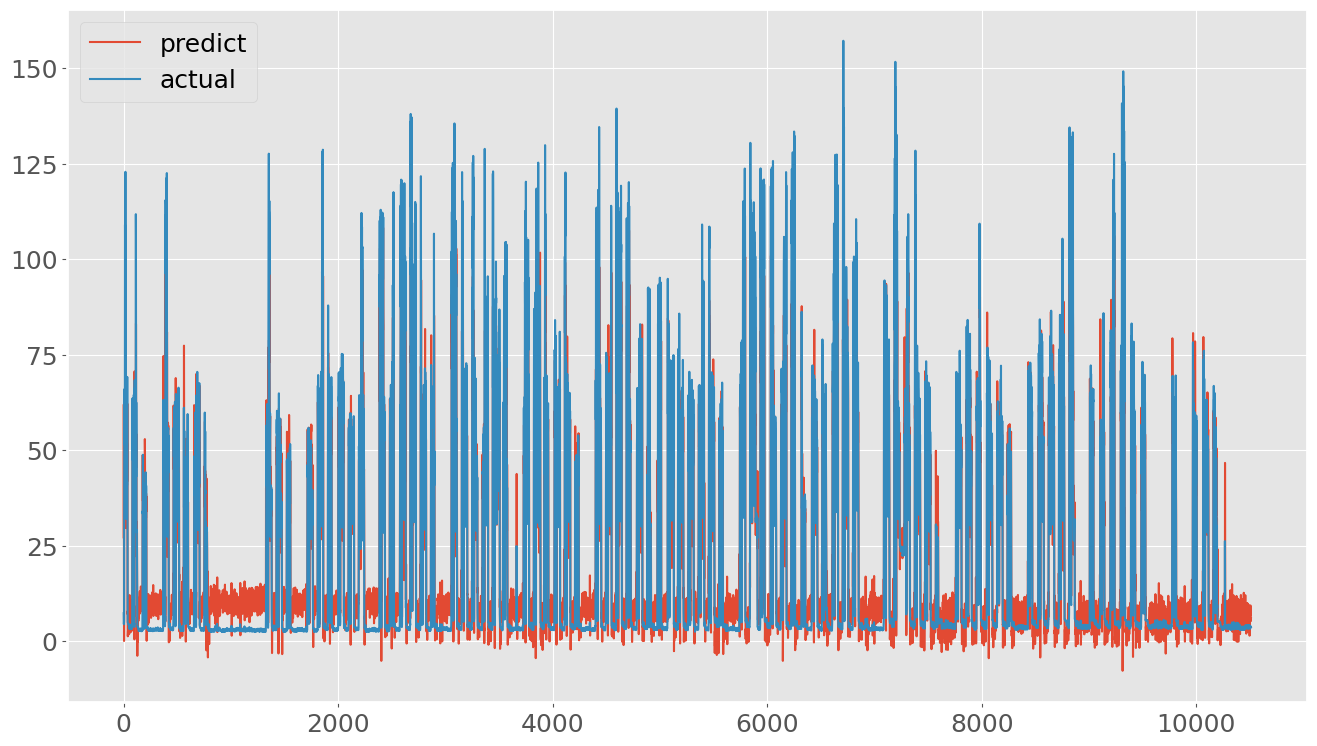

In [53]:
plt.plot(imf_fc + res.x[0], label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('ImprovedEMDSVR')
plt.show()

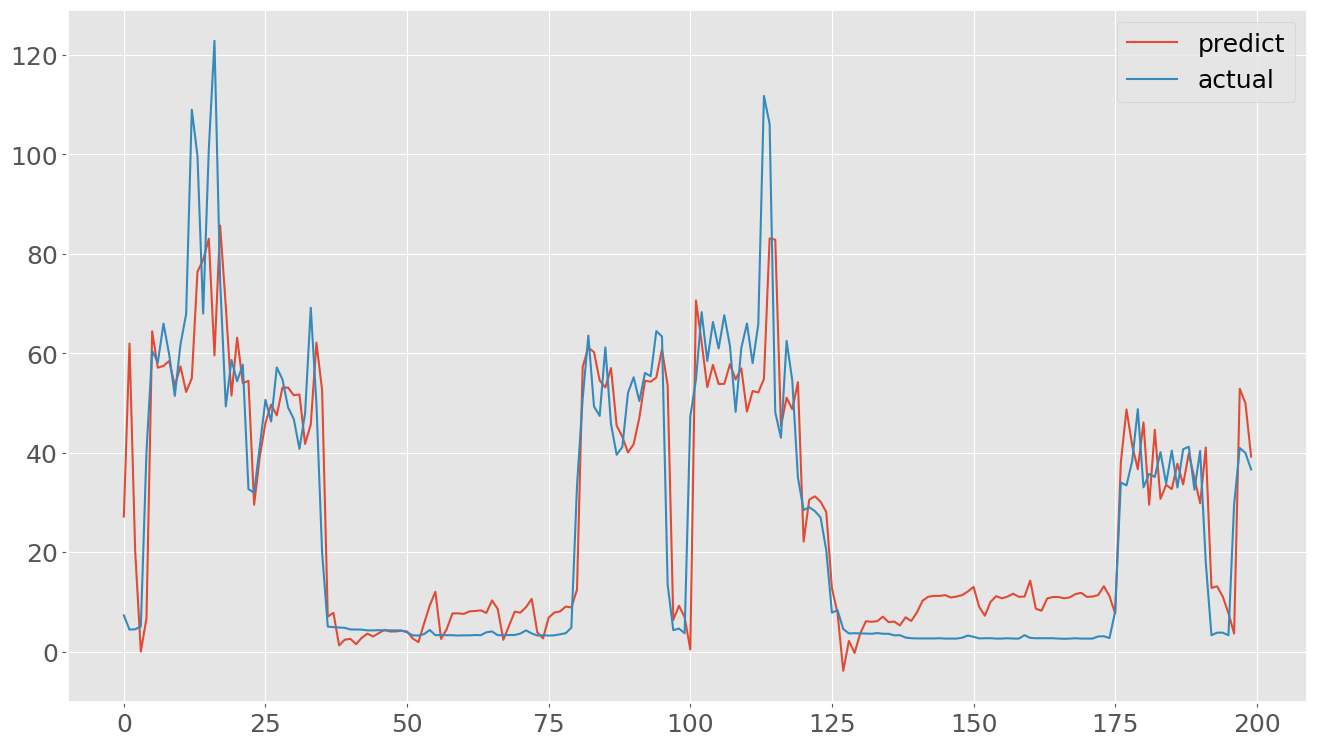

RMSE = 161.2115763195255 
MAE = 8.082470564921893 
MAPE = 1.058941505055023


In [54]:
plt.plot(imf_fc[:200] + res.x[0], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
plt.savefig('ImprovedEMDSVR_200')
plt.show()
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

# EEMD

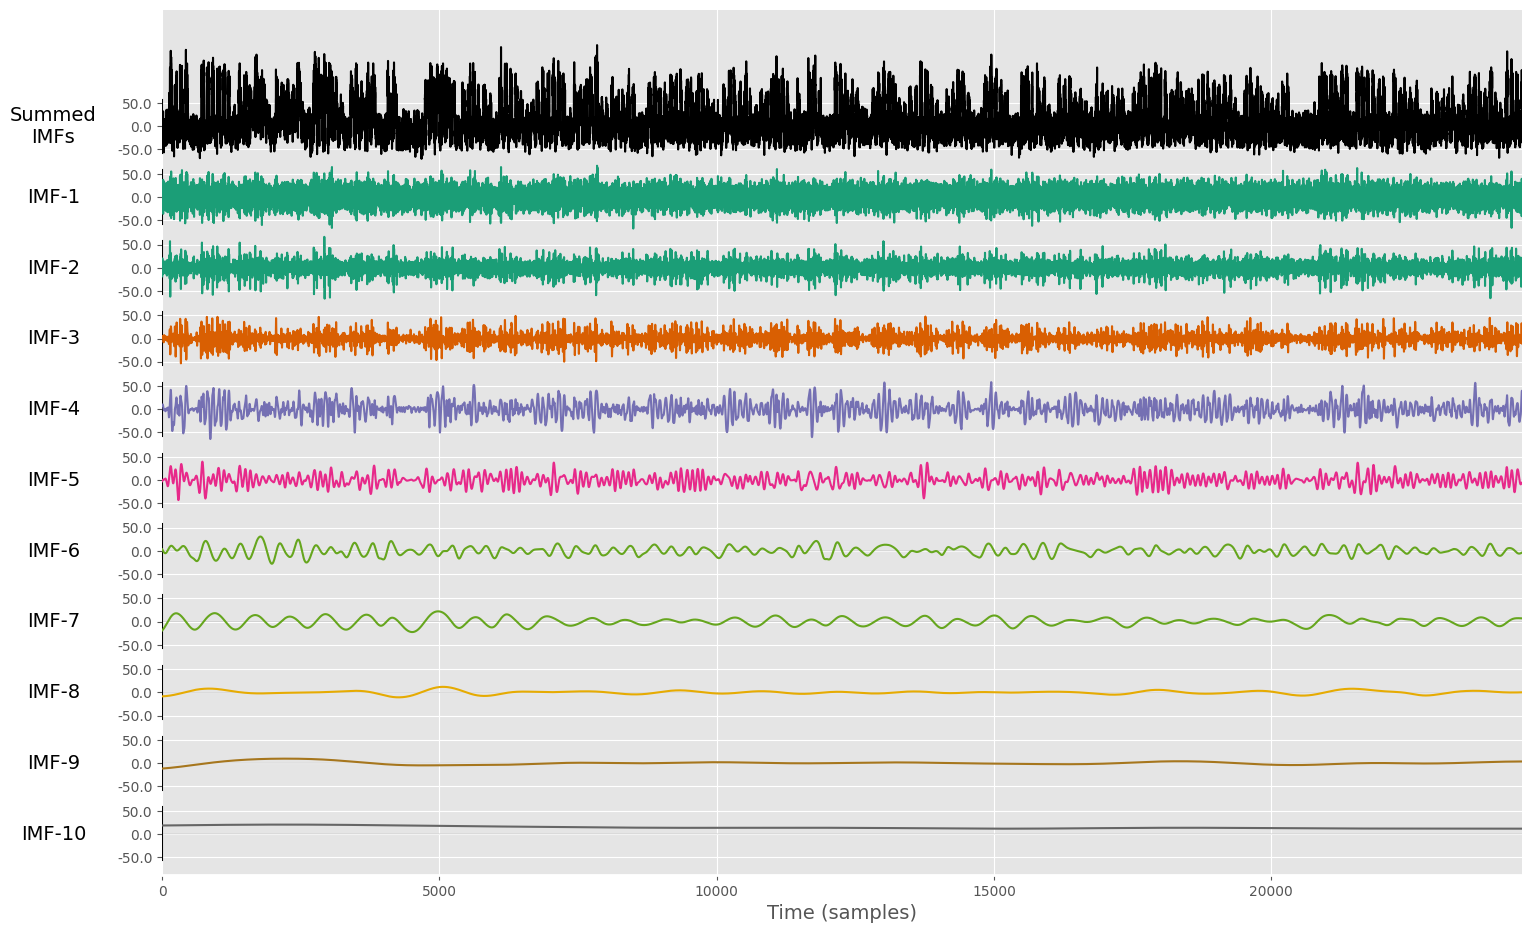

In [55]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)
plt.savefig('eemd')

In [56]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

imf_eemd_1  imf_eemd_2  imf_eemd_3  imf_eemd_4  imf_eemd_5  imf_eemd_6  \
0       26.652969  -18.510749    5.124563    9.195596   -2.446717    3.394834   
1        2.571991   -5.999853    3.981122    9.238654   -2.152337    3.154587   
2        3.833222   11.324292    2.870060    9.325360   -1.860633    2.915600   
3      -16.077938   20.181110    1.969222    9.453098   -1.575177    2.677895   
4       17.465376   14.932661    1.496661    9.618922   -1.299212    2.441498   
...           ...         ...         ...         ...         ...         ...   
24523   13.832931   -8.003123    0.519236   39.928105   -5.313111   -3.780932   
24524   -9.106848  -12.322511   -5.213623   39.409717   -5.227240   -3.706887   
24525   -6.796307  -13.317661   -9.384500   38.494546   -5.171723   -3.632068   
24526   -0.405070  -10.540428  -11.424137   37.192793   -5.149134   -3.556498   
24527    9.722418   -6.812006  -11.011300   35.519585   -5.160439   -3.480198   

       imf_eemd_7  imf_eemd_8  imf_eemd_9  imf_eemd_10  
0      -19.025525   -8.598765  -11.735822    18.161120  
1      -18.913993   -8.594454  -11.726686    18.162545  
2      -18.800007   -8.590027  -11.717526    18.163969  
3      -18.683595   -8.585485  -11.708344    18.165394  
4      -18.564788   -8.580827  -11.699138    18.166818  
...           ...         ...         ...          ...  
24523    7.018984    0.116871    3.572883    11.293145  
24524    7.008110    0.120326    3.572987    11.292933  
24525    6.997062    0.123783    3.573083    11.292721  
24526    6.985839    0.127243    3.573171    11.292508  
24527    6.974441    0.130705    3.573251    11.292295  

[24528 rows x 10 columns]

In [58]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

In [ ]:
# imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))

In [59]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

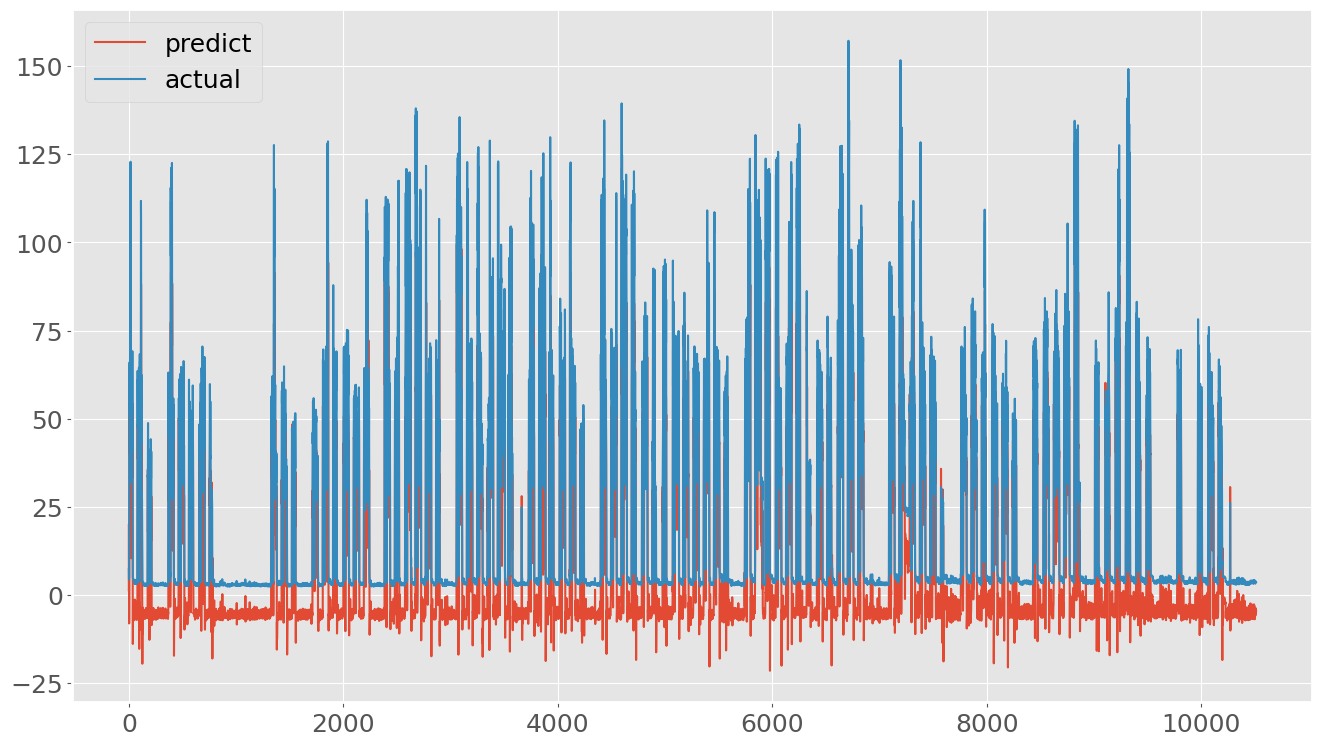

RMSE = 256.2792472944175 
MAE = 12.406646319632534 
MAPE = 1.7149915987139346


In [60]:
plt.plot(imf_eemd_fc,label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('EEMDSVR')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

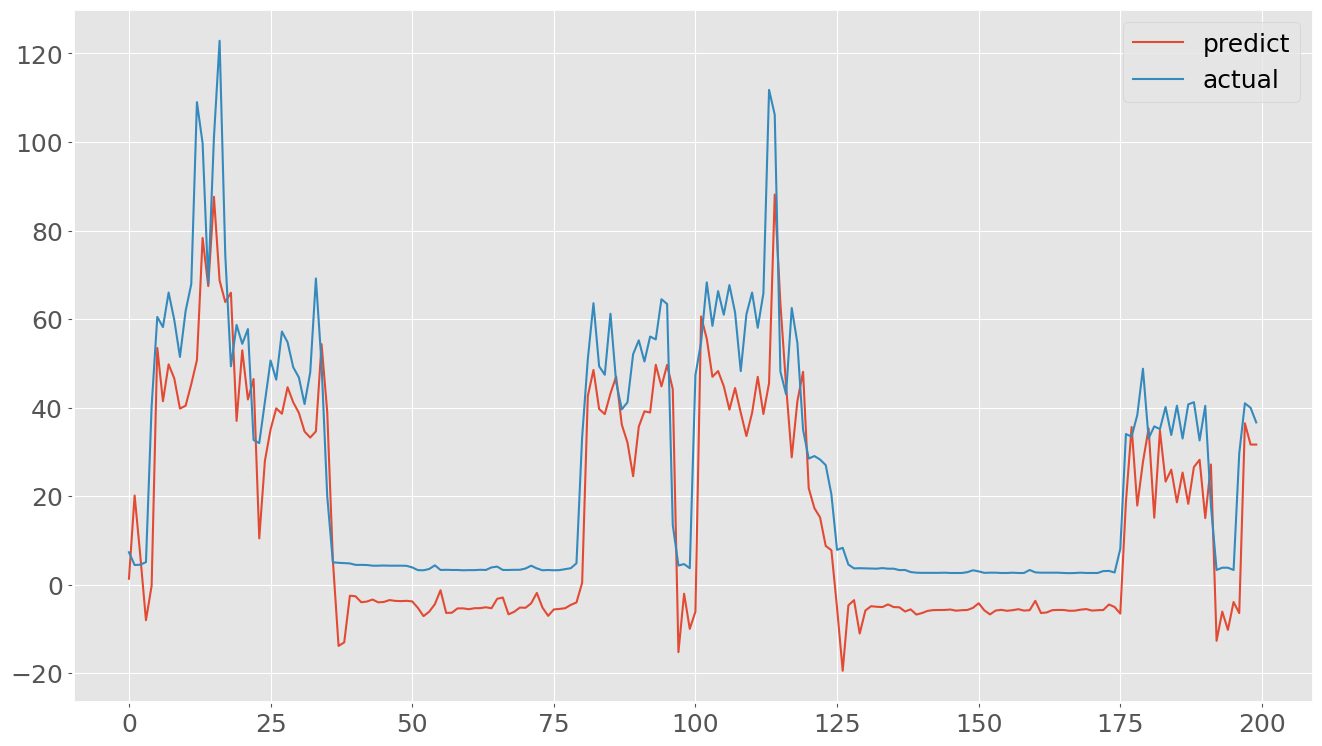

MSE = 256.2792472944175 
MAE = 12.406646319632534 
MAPE = 1.7149915987139346


In [61]:
plt.plot(imf_eemd_fc[:200], label = 'predict')
plt.plot(test[:200].values, label = 'actual')
plt.legend()
plt.savefig('EEMDSVR_200')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [62]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_train))
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_train))

imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

In [63]:
def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 169.672573
         Iterations: 45
         Function evaluations: 93
[11.61247754]


In [64]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 141.70276305158978 
MAE = 7.127892853601427 
MAPE = 0.7615795591231849


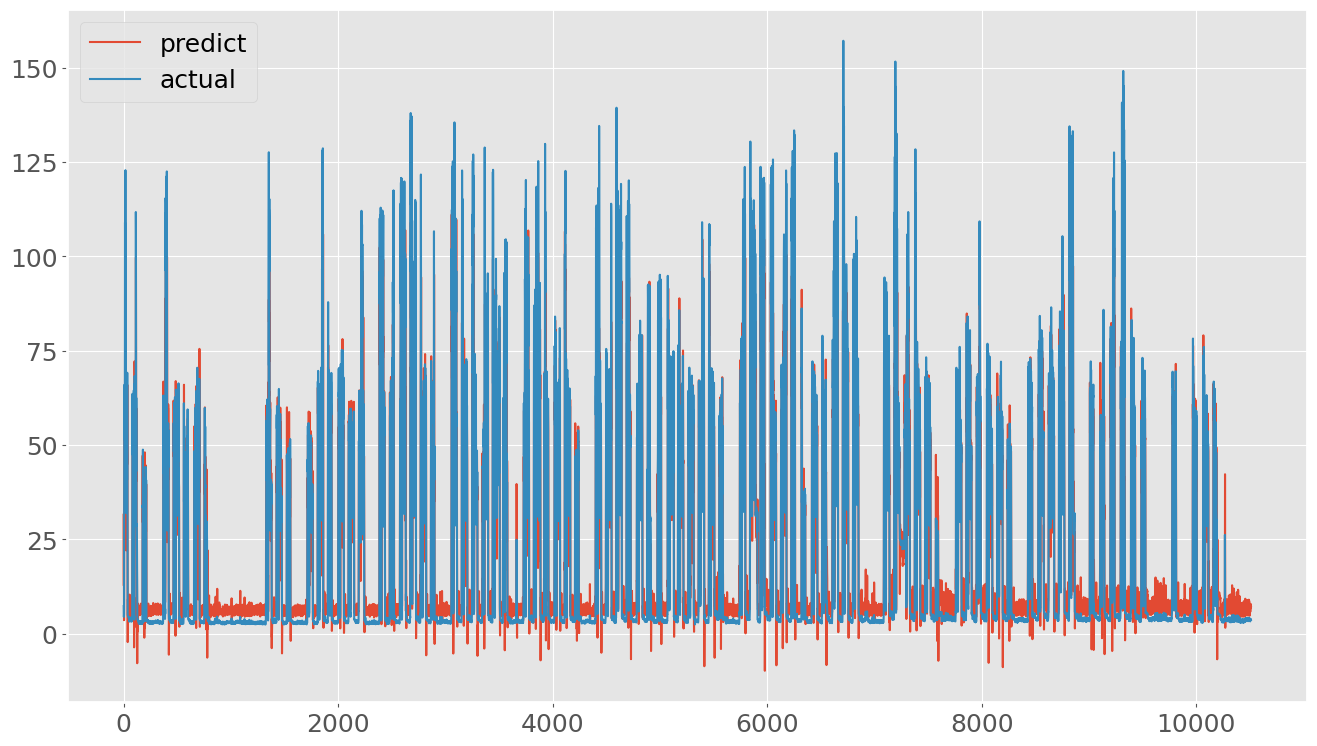

In [65]:
plt.plot(imf_eemd_fc + res1.x[0], label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
plt.savefig('ImprovedEEMDSVR')
plt.show()

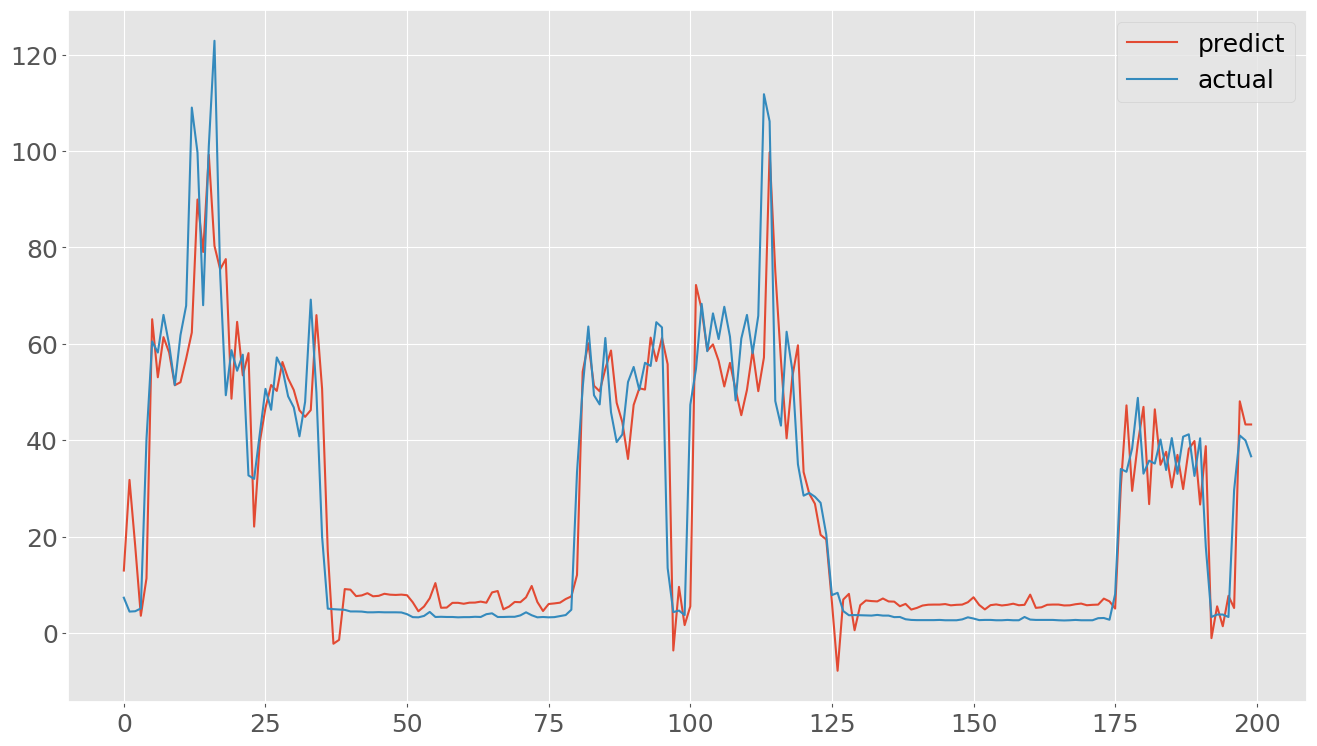

In [66]:
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
plt.savefig('ImprovedEEMDSVR_200')
plt.show()

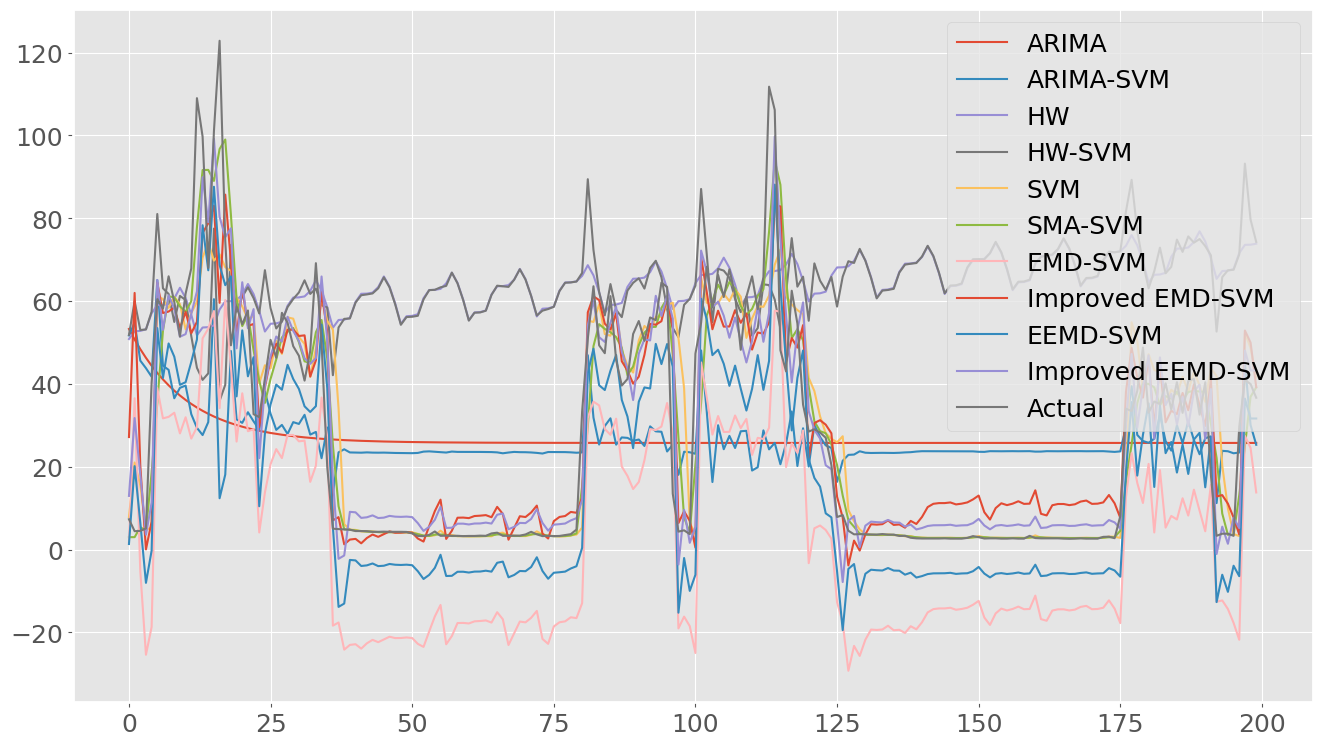

In [67]:
plt.plot(arima_fc.values[:200], label = 'ARIMA')
plt.plot(arima_SVR_fc[:200]+arima_fc.values[:200], label = 'ARIMA-SVM')
plt.plot(hw_fc.values[:200], label = 'HW')
plt.plot(hw_SVR_fc[:200]+hw_fc.values[:200], label = 'HW-SVM')
plt.plot(SVR_fc[:200], label = 'SVM')
plt.plot(SVR_MA_3_fc[0:200], label = 'SMA-SVM')
plt.plot(imf_fc[:200], label = 'EMD-SVM')
plt.plot(imf_fc[:200] + res.x[0], label = 'Improved EMD-SVM')
plt.plot(imf_eemd_fc[:200], label = 'EEMD-SVM')
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'Improved EEMD-SVM')
plt.plot(test.values[:200], label = 'Actual')
plt.legend()
plt.savefig('Summary')
plt.show()